In [ ]:
<img src="market.jpg" />

The scenario presented here is that you are a Data Analyst for a agri-food company that wishes to export its product internationally

This scenario was written in 2020 and you are asked to perform your analysis based on that

You are asked to separate the potential market (in this case the whole world) into groups and make recommendations on which markets to investigate first

There are 2 csv files provided, namely:

1. Food availability 2017
2. Population 2000 - 2018

You are asked to find other, pertinent data that fits within the PESTEL framework.

Once you have compiled the full dataframe you are asked to perform Principal Component Analysis (PCA) on your data and then use KMeans clustering and hierarchical clustering to find the relevant group(s).

In [ ]:
# Step 1: Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_pca_correlation_graph
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# Step 2: Import data

### Political Stability can have an impact on price, as well as the security of your drivers

In [2]:
#source: https://www.theglobaleconomy.com/rankings/wb_political_stability/

pol_stab = pd.read_csv(r"PoliticalStability_2000_2018.csv")

#there is no political stability information for 2001 so 2000 is removed as well. 
#I felt this could be done as this information is no longer very pertinent:
pol_stab = pol_stab[pol_stab.Year != 2000]
#removing 2018 because that is not pertinent to the current analysis:
pol_stab = pol_stab[pol_stab.Year != 2018]

pol_stab.head()

,Country,Year,Political_Stability
1,Afghanistan,2002,-2.04
2,Afghanistan,2003,-2.20
3,Afghanistan,2004,-2.30
4,Afghanistan,2005,-2.07
5,Afghanistan,2006,-2.22


In [3]:
#seperating out the political stability for 2017:
pol_stab_2017 = pol_stab[pol_stab.Year == 2017]
pol_stab_2017 = pol_stab_2017.reset_index()
pol_stab_2017.rename(columns={'Political_Stability': 'Pol Stab 2017'}, inplace=True)
pol_stab_2017.drop(['Year', 'index'], axis=1, inplace=True)
pol_stab_2017

,Country,Pol Stab 2017
0,Afghanistan,-2.80
1,Albanie,0.38
2,Algérie,-0.92
3,American Samoa,1.22
4,Andorra,1.42
...,...,...
193,Venezuela (République bolivarienne du),-1.25
194,Viet Nam,0.29
195,Yémen,-2.94
196,Zambie,0.15


In [4]:
#creating a new column with the average political stability per country 2002-2017:
avg_pol_stab_country = pol_stab.groupby("Country").mean().reset_index()
avg_pol_stab_country.drop('Year', axis=1, inplace=True)
avg_pol_stab_country.rename(columns={'Political_Stability': 'Avg Pol Stab 2002-2017'}, inplace=True)

#creating a single dataframe with political stability information:
pol_stab_info = pol_stab_2017.merge(avg_pol_stab_country, on='Country')
pol_stab_info

,Country,Pol Stab 2017,Avg Pol Stab 2002-2017
0,Afghanistan,-2.80,-2.444375
1,Albanie,0.38,-0.080625
2,Algérie,-0.92,-1.230000
3,American Samoa,1.22,0.963571
4,Andorra,1.42,1.344375
...,...,...,...
193,Venezuela (République bolivarienne du),-1.25,-1.180000
194,Viet Nam,0.29,0.226250
195,Yémen,-2.94,-2.111875
196,Zambie,0.15,0.295625


In [5]:
pol_stab_info.dtypes

Country                    object
Pol Stab 2017             float64
Avg Pol Stab 2002-2017    float64
dtype: object

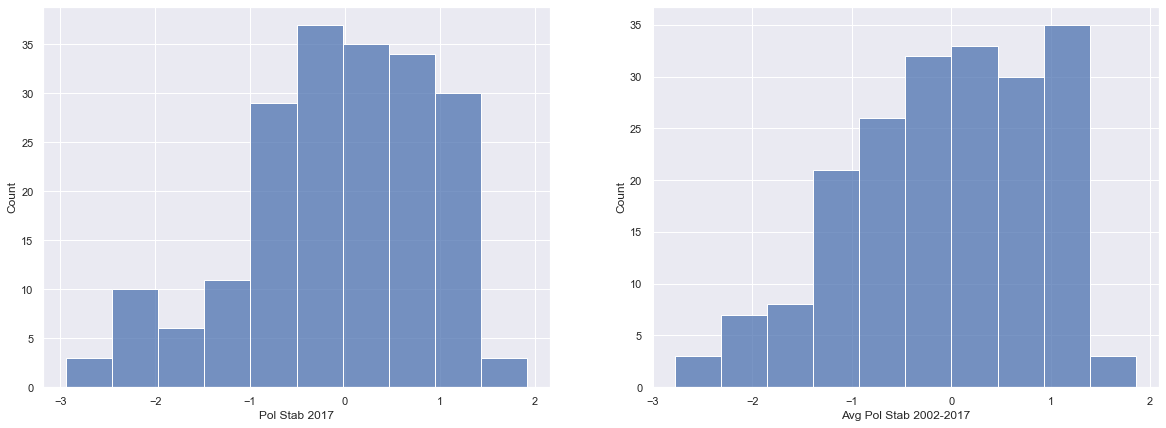

In [6]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
sns.histplot(pol_stab_info["Pol Stab 2017"])

plt.subplot(1,2,2)
sns.histplot(pol_stab_info["Avg Pol Stab 2002-2017"])
plt.show()

### Population numbers will give us our potential market

In [7]:
#source: https://www.fao.org/faostat/en/#data/OA
population = pd.read_excel(r"Population numbers.xlsx")
population.head()

,Pays,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,22600770.0,23680870.0,24726680.0,25654280.0,26433050.0,27100540.0,27722280.0,28394810.0,29185510.0,30117410.0,31161380.0,32269590.0,33370790.0,34413600.0,35383030.0,36296110.0
1,Afrique du Sud,46150910.0,46719200.0,47291610.0,47880600.0,48489460.0,49119760.0,49779470.0,50477010.0,51216960.0,52003760.0,52832660.0,53687120.0,54544190.0,55386370.0,56207650.0,57009760.0
2,Albanie,3126190.0,3118020.0,3104890.0,3086810.0,3063020.0,3034000.0,3002680.0,2973050.0,2948020.0,2928590.0,2914100.0,2903790.0,2896310.0,2890510.0,2886440.0,2884170.0
3,Algérie,31855110.0,32264160.0,32692160.0,33149720.0,33641000.0,34166970.0,34730610.0,35333880.0,35977460.0,36661450.0,37383900.0,38140130.0,38923690.0,39728030.0,40551390.0,41389190.0
4,Allemagne,81535120.0,81614380.0,81646470.0,81602740.0,81472230.0,81277830.0,81065750.0,80899960.0,80827000.0,80855630.0,80972630.0,81174370.0,81450380.0,81787410.0,82193770.0,82658410.0


In [8]:
#Creating a new column with the percentage population change 2006-2017
#I chose to use 2006 as first year because that's when Serbia and Montenegro split into 2 separate countries
#I chose to remove Sudan as it 1. split into 2 countries in 2013 and 2. isn't an interesting market for us

population["% Pop change 2006-2017"] = ((population[2017]-population[2006])/population[2006])*100
population.rename({'Pays': 'Country', 2017 : 'Population 2017'}, axis=1, inplace=True)
population = population[population.Country != 'Soudan']

#creating a single dataframe with pertinent population information:
population_info = population[["Country", 'Population 2017', "% Pop change 2006-2017"]]
population_info

,Country,Population 2017,% Pop change 2006-2017
0,Afghanistan,36296110.0,37.313363
1,Afrique du Sud,57009760.0,17.571447
2,Albanie,2884170.0,-5.839009
3,Algérie,41389190.0,23.031985
4,Allemagne,82658410.0,1.455932
...,...,...,...
229,Venezuela (République bolivarienne du),29402480.0,9.505668
230,Viet Nam,94600650.0,11.797920
231,Yémen,27834820.0,34.548003
232,Zambie,16853600.0,38.444869


In [9]:
population_info.dtypes

Country                    object
Population 2017           float64
% Pop change 2006-2017    float64
dtype: object

### Exchange rate has an impact on trade potential

In [10]:
#source: https://www.fao.org/faostat/en/#data/PE
taux_change = pd.read_csv(r"taux de change FAOSTAT_data_1-2022.csv")
taux_change.rename({'Zone': 'Country', 'Valeur': 'Avg Xchange rate to $'}, axis=1, inplace=True)

xchange_rate = taux_change[['Country', 'Avg Xchange rate to $']]
xchange_rate

,Country,Avg Xchange rate to $
0,Afghanistan,68.026904
1,Afrique du Sud,13.333781
2,Albanie,119.099667
3,Algérie,110.973017
4,Allemagne,0.885206
...,...,...
205,Venezuela,607.688224
206,Viet Nam,22370.086670
207,Yémen,250.250000
208,Zambie,9.519501


In [11]:
xchange_rate.dtypes

Country                   object
Avg Xchange rate to $    float64
dtype: object

### GDP and GDP per capita give an indication of the potential Sales Market

In [12]:
#source: https://www.worldometers.info/gdp/gdp-by-country/
gdp = pd.read_excel(r"GDP 2017(1).xlsx")
gdp_info = gdp[['Country', 'GDP (nominal, 2017)', 'GDP per capita']]
gdp_info

,Country,"GDP (nominal, 2017)",GDP per capita
0,Afghanistan,19543976895,538
1,Albanie,13038538300,4521
2,Algérie,167555280113,4048
3,American Samoa,634000000,11399
4,Andorra,3012914131,39128
...,...,...,...
185,Vanuatu,862879789,3022
186,Viet Nam,223779865815,2366
187,Yémen,31267675216,1123
188,Zambie,25868142073,1535


In [13]:
gdp_info.dtypes

Country                object
GDP (nominal, 2017)     int64
GDP per capita          int64
dtype: object

### Number of KFC and McDonald's restaurants can be used as an indication of Sales Market potential as well

In [14]:
#source: https://www.caribbeansignal.com/2019/11/28/countries-with-the-largest-number-of-kfc-restaurants-per-100000-people-by-country/
kfc = pd.read_excel(r"KFC per country.xlsx")

#Finding the real number of restaurants by dividing population per country by 100k and then multiplying it by the
#number of stores per 100k
kfc2 = population_info.merge(kfc, on='Country')
kfc2["KFC_stores"] = round((kfc2["Population 2017"]/100000)*kfc2["# of KFC Stores"],0)

#Creating a dataframe with only the relevant information
kfc_info = kfc2[['Country', 'KFC_stores']]
kfc_info.head()

,Country,KFC_stores
0,Afrique du Sud,521069.0
1,Albanie,58.0
2,Allemagne,142999.0
3,Angola,2684.0
4,Antigua-et-Barbuda,2.0


In [15]:
kfc_info.dtypes

Country        object
KFC_stores    float64
dtype: object

In [16]:
# source: https://www.atlasbig.com/en-us/countries-mcdonalds-shops
mcdo = pd.read_excel(r"McDo per country.xlsx")
mcdo.rename({'Number of Restaurants': 'McDonalds_Stores'}, axis=1, inplace=True)
mcdo.head()

,Country,McDonalds_Stores
0,États-Unis d'Amérique,14146
1,Japon,2975
2,"Chine, continentale",2391
3,Allemagne,1476
4,Canada,1450


In [17]:
mcdo.dtypes

Country             object
McDonalds_Stores     int64
dtype: object

### Distance from Paris to the centroid of the destination country. Distance will have a direct impact on cost

In [18]:
###source: https://www.freemaptools.com/how-far-is-it-between.htm, Origin point = Paris
distance = pd.read_excel(r"Distance.xlsx")
distance.head()

,Country,Distance (km)
0,Afghanistan,5583.528
1,Afrique du Sud,9063.963
2,Albanie,1635.822
3,Algérie,2316.022
4,Allemagne,632.765


In [19]:
distance.dtypes

Country           object
Distance (km)    float64
dtype: object

### Food Availability. This gives indications of Sales Market as well as potential Competitors.

In [20]:
#source: provided by company
info_alimentaire = pd.read_csv(r"DisponibiliteAlimentaire_2017.csv")
info_alimentaire.rename({'Zone': 'Country'}, axis=1, inplace=True)
info_alimentaire.drop(['Année'], axis=1, inplace=True)
info_alimentaire.head()

,Country,Élément,Produit,Unité,Valeur
0,Afghanistan,Production,Blé et produits,Milliers de tonnes,4281.0
1,Afghanistan,Importations - Quantité,Blé et produits,Milliers de tonnes,2302.0
2,Afghanistan,Variation de stock,Blé et produits,Milliers de tonnes,-119.0
3,Afghanistan,Exportations - Quantité,Blé et produits,Milliers de tonnes,0.0
4,Afghanistan,Disponibilité intérieure,Blé et produits,Milliers de tonnes,6701.0


In [21]:
#Having a look at all the available products in the dataframe
info_alimentaire.Produit.unique()

array(['Blé et produits', 'Riz et produits', 'Orge et produits',
       'Maïs et produits', 'Seigle et produits', 'Avoine',
       'Millet et produits', 'Sorgho et produits', 'Céréales, Autres',
       'Pommes de Terre et produits', 'Ignames', 'Racines nda',
       'Sucre, canne', 'Sucre, betterave', 'Sucre Eq Brut',
       'Edulcorants Autres', 'Miel', 'Haricots', 'Pois',
       'Légumineuses Autres et produits', 'Noix et produits', 'Soja',
       'Arachides Decortiquees', 'Graines de tournesol',
       'Graines Colza/Moutarde', 'Graines de coton', 'Coco (Incl Coprah)',
       'Sésame', 'Olives', 'Plantes Oleiferes, Autre', 'Huile de Soja',
       "Huile d'Arachide", 'Huile de Tournesol',
       'Huile de Colza&Moutarde', 'Huile Graines de Coton',
       'Huile de Palmistes', 'Huile de Palme', 'Huile de Coco',
       'Huile de Sésame', "Huile d'Olive", 'Huile de Son de Riz',
       'Huile de Germe de Maïs', 'Huil Plantes Oleif Autr',
       'Tomates et produits', 'Oignons', 'Légumes, 

In [22]:
#Separating out the product that concerns us (Chicken)
#In the provided information there is no separate product for Chicken but there is one for Poultry (Viande de Volailles)
info_alimentaire = info_alimentaire[info_alimentaire.Produit == 'Viande de Volailles']

#Turning the value into tonnes to be able to compare it with other measures in our dataframe later
info_alimentaire['Valeur (tonnes)'] = info_alimentaire['Valeur']*1000
info_alimentaire.drop(['Produit', 'Unité', 'Valeur'], axis=1, inplace=True)
info_alimentaire

,Country,Élément,Valeur (tonnes)
651,Afghanistan,Production,28000.0
652,Afghanistan,Importations - Quantité,29000.0
653,Afghanistan,Variation de stock,0.0
654,Afghanistan,Disponibilité intérieure,57000.0
655,Afghanistan,Pertes,2000.0
...,...,...,...
176396,Zimbabwe,Nourriture,67000.0
176397,Zimbabwe,Disponibilité alimentaire en quantité (kg/pers...,4680.0
176398,Zimbabwe,Disponibilité alimentaire (Kcal/personne/jour),16000.0
176399,Zimbabwe,Disponibilité de protéines en quantité (g/pers...,1590.0


In [23]:
#Identifying the different elements in the dataframe
info_alimentaire.Élément.unique()

array(['Production', 'Importations - Quantité', 'Variation de stock',
       'Disponibilité intérieure', 'Pertes', 'Résidus', 'Nourriture',
       'Disponibilité alimentaire en quantité (kg/personne/an)',
       'Disponibilité alimentaire (Kcal/personne/jour)',
       'Disponibilité de protéines en quantité (g/personne/jour)',
       'Disponibilité de matière grasse en quantité (g/personne/jour)',
       'Exportations - Quantité', 'Alimentation pour touristes',
       'Traitement', 'Autres utilisations (non alimentaire)',
       'Aliments pour animaux', 'Semences'], dtype=object)

In [24]:
#Separating out the relavant elements: Production, import and export
elements = ['Production', 'Importations - Quantité', 'Exportations - Quantité']
rel_info = info_alimentaire.loc[info_alimentaire['Élément'].isin(elements)]
rel_info

,Country,Élément,Valeur (tonnes)
651,Afghanistan,Production,28000.0
652,Afghanistan,Importations - Quantité,29000.0
1704,Afrique du Sud,Production,1667000.0
1705,Afrique du Sud,Importations - Quantité,514000.0
1707,Afrique du Sud,Exportations - Quantité,63000.0
...,...,...,...
175361,Zambie,Production,49000.0
175362,Zambie,Importations - Quantité,12000.0
175364,Zambie,Exportations - Quantité,1000.0
176388,Zimbabwe,Production,69000.0


In [25]:
#Pivoting the table to get the relevant information per Country
#so we can merge it with our other data
rel_info_pt = rel_info.pivot_table(index=['Country'], columns=["Élément"], values='Valeur (tonnes)', fill_value=0)
rel_info_pt.reset_index(inplace=True)
rel_info_pt.rename(columns={'Exportations - Quantité': 'Viande Volaille, Export de Country vers monde (tonnes)',\
                            'Importations - Quantité': 'Viande Volaille, Import de monde vers Country (tonnes)',\
                           'Production': 'Production (tonnes)'},inplace=True)
rel_info_pt

Élément,Country,"Viande Volaille, Export de Country vers monde (tonnes)","Viande Volaille, Import de monde vers Country (tonnes)",Production (tonnes)
0,Afghanistan,0,29000,28000
1,Afrique du Sud,63000,514000,1667000
2,Albanie,0,38000,13000
3,Algérie,0,2000,275000
4,Allemagne,646000,842000,1514000
...,...,...,...,...
165,Émirats arabes unis,94000,433000,48000
166,Équateur,0,0,340000
167,États-Unis d'Amérique,3692000,123000,21914000
168,Éthiopie,0,1000,14000


In [26]:
rel_info_pt.dtypes

Élément
Country                                                   object
Viande Volaille, Export de Country vers monde (tonnes)     int64
Viande Volaille, Import de monde vers Country (tonnes)     int64
Production (tonnes)                                        int64
dtype: object

<font color='blue'>The above Export figures represent exports from the Country to the rest of the world.</font>

### French Poultry exports 2017. Gives us an indication which countries are already good customers

In [27]:
#source: https://www.fao.org/faostat/en/#data/TM
chicken_trade = pd.read_csv(r"Comm Poulet FAOSTAT_data_1-2022.csv")
chicken_trade.rename({'Pays partenaires': 'Country'}, axis=1, inplace=True)
chicken_trade = chicken_trade[chicken_trade.Unité == 'tonnes']

#removing the product Poulets, as we will not be exporting live chickens
chicken_trade = chicken_trade[chicken_trade.Produit != 'Poulets']
chicken_trade

,Pays déclarants,Country,élément,Produit,Année,Valeur,Unité
0,France,Afghanistan,Exportations - Quantité,"Viande, volaille",2017,244,tonnes
2,France,Afrique du Sud,Exportations - Quantité,"Viande, poulet en boîte",2017,1,tonnes
7,France,Albanie,Exportations - Quantité,"Viande, poulet en boîte",2017,10,tonnes
9,France,Albanie,Exportations - Quantité,"Viande, volaille",2017,78,tonnes
14,France,Algérie,Exportations - Quantité,"Viande, poulet en boîte",2017,46,tonnes
...,...,...,...,...,...,...,...
646,France,Vanuatu,Exportations - Quantité,"Viande, poulet en boîte",2017,0,tonnes
648,France,Venezuela,Exportations - Quantité,"Viande, poulet en boîte",2017,0,tonnes
653,France,Viet Nam,Exportations - Quantité,"Viande, poulet en boîte",2017,34,tonnes
655,France,Viet Nam,Exportations - Quantité,"Viande, volaille",2017,1202,tonnes


In [28]:
export_info = chicken_trade[['Country', 'Produit', 'Valeur']]
export_info

,Country,Produit,Valeur
0,Afghanistan,"Viande, volaille",244
2,Afrique du Sud,"Viande, poulet en boîte",1
7,Albanie,"Viande, poulet en boîte",10
9,Albanie,"Viande, volaille",78
14,Algérie,"Viande, poulet en boîte",46
...,...,...,...
646,Vanuatu,"Viande, poulet en boîte",0
648,Venezuela,"Viande, poulet en boîte",0
653,Viet Nam,"Viande, poulet en boîte",34
655,Viet Nam,"Viande, volaille",1202


In [29]:
##Pivoting the table to get the relevant information per Country
#so we can merge it with our other data
export_info_pt = export_info.pivot_table(index=['Country'], columns=["Produit"], values='Valeur', fill_value=0)
export_info_pt.reset_index(inplace=True)
export_info_pt.rename(columns={'Viande, poulet en boîte': 'Poulet (boîte), export de France vers Country (tonnes)',\
                            'Viande, volaille': 'Viande volaille, export de France vers Country (tonnes)'},inplace=True)
export_info_pt

Produit,Country,"Poulet (boîte), export de France vers Country (tonnes)","Viande volaille, export de France vers Country (tonnes)"
0,Afghanistan,0,244
1,Afrique du Sud,1,0
2,Albanie,10,78
3,Algérie,46,0
4,Allemagne,1377,18920
...,...,...,...
129,Yémen,0,4721
130,Égypte,10,6623
131,Émirats arabes unis,278,7557
132,États-Unis d'Amérique,0,0


In [30]:
export_info_pt.dtypes

Produit
Country                                                    object
Poulet (boîte), export de France vers Country (tonnes)      int64
Viande volaille, export de France vers Country (tonnes)     int64
dtype: object

<font color='blue'>The above Export figures represent exports from the France to that Country.</font>

# Step 3: Merge Dataframes

In [31]:
merge_dfs = export_info_pt.merge(kfc_info, on='Country', how='outer').merge(mcdo, on='Country', how='outer')\
.merge(gdp_info, on='Country', how='outer').merge(population_info, on='Country', how='outer').merge(xchange_rate, on='Country', how='outer')\
.merge(pol_stab_info, on='Country', how='outer').merge(distance, on='Country', how='outer').fillna(0)
merge_dfs

,Country,"Poulet (boîte), export de France vers Country (tonnes)","Viande volaille, export de France vers Country (tonnes)",KFC_stores,McDonalds_Stores,"GDP (nominal, 2017)",GDP per capita,Population 2017,% Pop change 2006-2017,Avg Xchange rate to $,Pol Stab 2017,Avg Pol Stab 2002-2017,Distance (km)
0,Afghanistan,0.0,244.0,0.0,0.0,1.954398e+10,538.0,36296110.0,37.313363,68.026904,-2.80,-2.444375,5583.528
1,Afrique du Sud,1.0,0.0,521069.0,252.0,3.488716e+11,6120.0,57009760.0,17.571447,13.333781,-0.28,-0.094375,9063.963
2,Albanie,10.0,78.0,58.0,0.0,1.303854e+10,4521.0,2884170.0,-5.839009,119.099667,0.38,-0.080625,1635.822
3,Algérie,46.0,0.0,0.0,0.0,1.675553e+11,4048.0,41389190.0,23.031985,110.973017,-0.92,-1.230000,2316.022
4,Allemagne,1377.0,18920.0,142999.0,1476.0,3.693204e+12,44680.0,82658410.0,1.455932,0.885206,0.59,0.831250,632.765
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,Papua New Guinée,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,-0.70,-0.640000,0.000
278,Puerto Rico,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,0.48,0.467500,0.000
279,Soudan Sud,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,-2.45,-2.031429,0.000
280,Syrian Arab Republic,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,-2.62,-1.332500,0.000


In [32]:
#Using a left merge to create a dataframe with the countries represented in the source data provided by the company
full_data = rel_info_pt.merge(merge_dfs, on='Country', how='left').fillna(0)
full_data

,Country,"Viande Volaille, Export de Country vers monde (tonnes)","Viande Volaille, Import de monde vers Country (tonnes)",Production (tonnes),"Poulet (boîte), export de France vers Country (tonnes)","Viande volaille, export de France vers Country (tonnes)",KFC_stores,McDonalds_Stores,"GDP (nominal, 2017)",GDP per capita,Population 2017,% Pop change 2006-2017,Avg Xchange rate to $,Pol Stab 2017,Avg Pol Stab 2002-2017,Distance (km)
0,Afghanistan,0,29000,28000,0.0,244.0,0.0,0.0,1.954398e+10,538.0,36296110.0,37.313363,68.026904,-2.80,-2.444375,5583.528
1,Afrique du Sud,63000,514000,1667000,1.0,0.0,521069.0,252.0,3.488716e+11,6120.0,57009760.0,17.571447,13.333781,-0.28,-0.094375,9063.963
2,Albanie,0,38000,13000,10.0,78.0,58.0,0.0,1.303854e+10,4521.0,2884170.0,-5.839009,119.099667,0.38,-0.080625,1635.822
3,Algérie,0,2000,275000,46.0,0.0,0.0,0.0,1.675553e+11,4048.0,41389190.0,23.031985,110.973017,-0.92,-1.230000,2316.022
4,Allemagne,646000,842000,1514000,1377.0,18920.0,142999.0,1476.0,3.693204e+12,44680.0,82658410.0,1.455932,0.885206,0.59,0.831250,632.765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,Émirats arabes unis,94000,433000,48000,278.0,7557.0,14326.0,165.0,3.825751e+11,40325.0,9487200.0,78.998032,3.672500,0.62,0.829375,5249.794
166,Équateur,0,0,340000,0.0,0.0,24171.0,0.0,1.042959e+11,6214.0,16785360.0,19.389048,1.000000,0.00,0.000000,9515.114
167,États-Unis d'Amérique,3692000,123000,21914000,0.0,0.0,13204943.0,14146.0,1.948539e+13,59939.0,325084760.0,9.177151,1.000000,0.34,0.393125,7520.141
168,Éthiopie,0,1000,14000,20.0,42.0,0.0,0.0,0.000000e+00,0.0,106399920.0,35.559932,23.866104,-1.68,-1.550000,5660.203


### Checking the correlation between variables

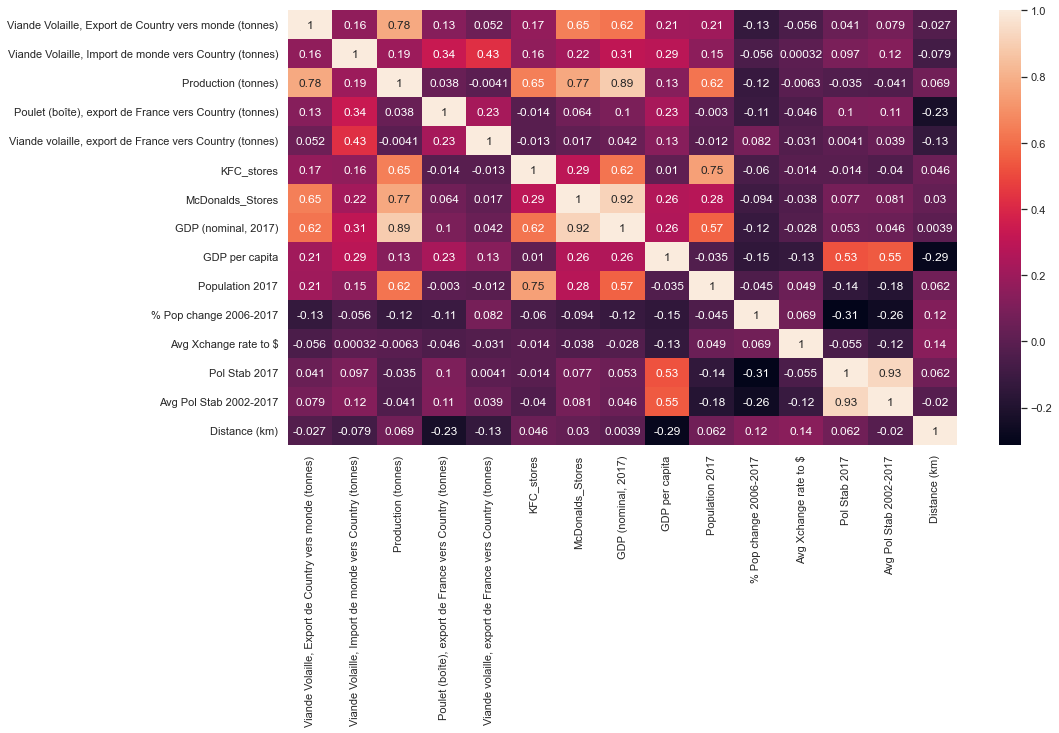

In [33]:
corrMatrix = full_data.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corrMatrix, annot=True)
plt.show()

<font color='blue'>As we can see, the number of McDonalds Stores has a very high correlation with GDP. Also, Political Stability 2017 has a very high correlation with the average Political Stability 2002-2017</font>

In [34]:
#Removing the features with over 0.9 correlation
full_data_corr = full_data.drop(['McDonalds_Stores','Avg Pol Stab 2002-2017'],axis=1)
full_data_corr

,Country,"Viande Volaille, Export de Country vers monde (tonnes)","Viande Volaille, Import de monde vers Country (tonnes)",Production (tonnes),"Poulet (boîte), export de France vers Country (tonnes)","Viande volaille, export de France vers Country (tonnes)",KFC_stores,"GDP (nominal, 2017)",GDP per capita,Population 2017,% Pop change 2006-2017,Avg Xchange rate to $,Pol Stab 2017,Distance (km)
0,Afghanistan,0,29000,28000,0.0,244.0,0.0,1.954398e+10,538.0,36296110.0,37.313363,68.026904,-2.80,5583.528
1,Afrique du Sud,63000,514000,1667000,1.0,0.0,521069.0,3.488716e+11,6120.0,57009760.0,17.571447,13.333781,-0.28,9063.963
2,Albanie,0,38000,13000,10.0,78.0,58.0,1.303854e+10,4521.0,2884170.0,-5.839009,119.099667,0.38,1635.822
3,Algérie,0,2000,275000,46.0,0.0,0.0,1.675553e+11,4048.0,41389190.0,23.031985,110.973017,-0.92,2316.022
4,Allemagne,646000,842000,1514000,1377.0,18920.0,142999.0,3.693204e+12,44680.0,82658410.0,1.455932,0.885206,0.59,632.765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,Émirats arabes unis,94000,433000,48000,278.0,7557.0,14326.0,3.825751e+11,40325.0,9487200.0,78.998032,3.672500,0.62,5249.794
166,Équateur,0,0,340000,0.0,0.0,24171.0,1.042959e+11,6214.0,16785360.0,19.389048,1.000000,0.00,9515.114
167,États-Unis d'Amérique,3692000,123000,21914000,0.0,0.0,13204943.0,1.948539e+13,59939.0,325084760.0,9.177151,1.000000,0.34,7520.141
168,Éthiopie,0,1000,14000,20.0,42.0,0.0,0.000000e+00,0.0,106399920.0,35.559932,23.866104,-1.68,5660.203


# step 4: perform PCA on data

#### Because of the relatively large number of features performing Principal Component Analysis was considered beneficial

In [35]:
#preparing dataframe for scaling by setting Country (the only non-numerical data) as index
full_to_scale = full_data_corr.set_index('Country')
full_to_scale

,"Viande Volaille, Export de Country vers monde (tonnes)","Viande Volaille, Import de monde vers Country (tonnes)",Production (tonnes),"Poulet (boîte), export de France vers Country (tonnes)","Viande volaille, export de France vers Country (tonnes)",KFC_stores,"GDP (nominal, 2017)",GDP per capita,Population 2017,% Pop change 2006-2017,Avg Xchange rate to $,Pol Stab 2017,Distance (km)
Country,,,,,,,,,,,,,
Afghanistan,0,29000,28000,0.0,244.0,0.0,1.954398e+10,538.0,36296110.0,37.313363,68.026904,-2.80,5583.528
Afrique du Sud,63000,514000,1667000,1.0,0.0,521069.0,3.488716e+11,6120.0,57009760.0,17.571447,13.333781,-0.28,9063.963
Albanie,0,38000,13000,10.0,78.0,58.0,1.303854e+10,4521.0,2884170.0,-5.839009,119.099667,0.38,1635.822
Algérie,0,2000,275000,46.0,0.0,0.0,1.675553e+11,4048.0,41389190.0,23.031985,110.973017,-0.92,2316.022
Allemagne,646000,842000,1514000,1377.0,18920.0,142999.0,3.693204e+12,44680.0,82658410.0,1.455932,0.885206,0.59,632.765
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,94000,433000,48000,278.0,7557.0,14326.0,3.825751e+11,40325.0,9487200.0,78.998032,3.672500,0.62,5249.794
Équateur,0,0,340000,0.0,0.0,24171.0,1.042959e+11,6214.0,16785360.0,19.389048,1.000000,0.00,9515.114
États-Unis d'Amérique,3692000,123000,21914000,0.0,0.0,13204943.0,1.948539e+13,59939.0,325084760.0,9.177151,1.000000,0.34,7520.141


In [36]:
#When performing Scaling (the next step) I was confronted with an infinity error
#Checking which rows and columns had infinity values

print()
print("printing column name where infinity is present")
col_name = full_to_scale.columns.to_series()[np.isinf(full_to_scale).any()]
print(col_name)

print()
print("printing row index with infinity ")
  
r = full_to_scale.index[np.isinf(full_to_scale).any(1)]
print(r)

print(full_data.Country.loc[[100, 136, 140]])
#Serbia, Montenegro and Sudan didn't exist in 2002 so '% Pop change 2002-2017' gave me infinity values.
#Serbia & Montenegro became separate states in 2006 therefore I changed the calculation to '% Pop change 2006-2017'.
#I removed Sudan (which only became a state in 2012) due to its low or negative values for most other features.


printing column name where infinity is present
Series([], dtype: object)

printing row index with infinity 
Index([], dtype='object', name='Country')
100    Monténégro
136        Serbie
140        Soudan
Name: Country, dtype: object


<font color='blue'>The above actions are no longer necessary as the faults have been corrected but I wished to keep them in the notebook to explain some of the decisions that were made</font>

#### Scaling the data to give equal weight to all features

In [37]:
full_data_scaled = StandardScaler().fit_transform(full_to_scale)
np.mean(full_data_scaled),np.std(full_data_scaled)

(6.430251002353848e-18, 1.0)

#### Finding the adequate number of components

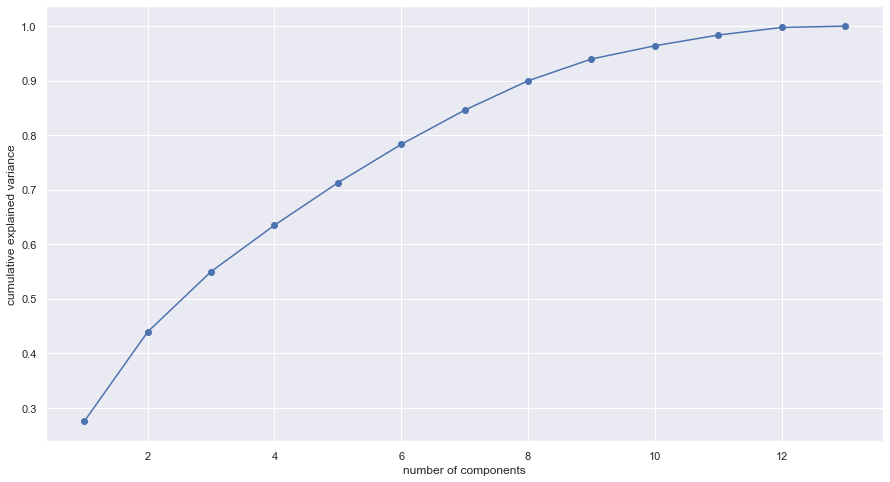

In [38]:
pca1 = PCA().fit(full_data_scaled)
plt.plot(range(1,14), np.cumsum(pca1.explained_variance_ratio_), marker = "o")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

<font color='blue'>It was decided that 4 components, explaining 65% of the cumulative variance, was sufficient for the purposes of this analysis.</font>

#### Creating Correlation Circles for the first and second as well as the third and fourth components

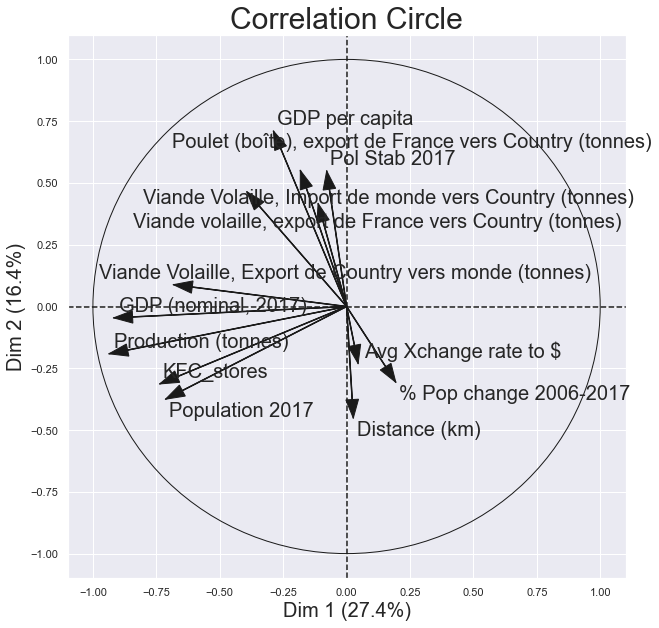

In [39]:
attribute_names = full_to_scale.columns
fig, correlation_matrix = plot_pca_correlation_graph(
    full_data_scaled, 
    attribute_names,
    dimensions=(1, 2),
    figure_axis_size=10
    )

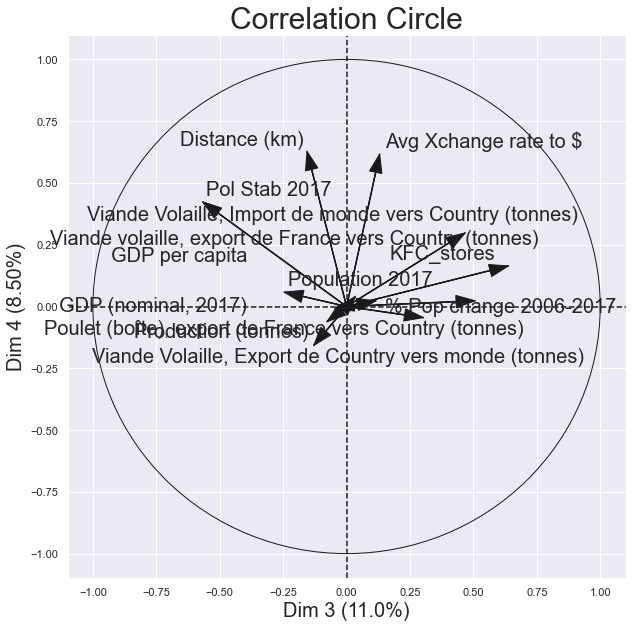

In [40]:
fig, correlation_matrix = plot_pca_correlation_graph(
    full_data_scaled, 
    attribute_names,
    dimensions=(3, 4),
    figure_axis_size=10
)

#### Performing PCA with the previously observed number of components

In [41]:
pca2 = PCA(n_components = 4)
pca_poulet = pca2.fit_transform(full_data_scaled)

In [42]:
#Creating a dataframe with the PCA results
principal_poulet_df = pd.DataFrame(data = pca_poulet
             , columns = ['pc 1', 'pc 2', 'pc 3', 'pc 4'])
principal_poulet_df

,pc 1,pc 2,pc 3,pc 4
0,-0.832773,-1.830648,1.872250,-1.513422
1,0.525750,0.041561,0.801460,0.815691
2,-0.450453,0.537202,-0.835441,-0.699667
3,-0.546355,-0.580154,0.507630,-1.209393
4,2.928367,3.748251,1.709270,0.649801
...,...,...,...,...
165,0.022051,1.199524,1.996154,0.858551
166,-0.555255,-0.624027,-0.368657,0.273911
167,13.956146,-0.520835,-2.653697,-1.238838
168,-0.641147,-1.518915,1.207101,-1.045425


<AxesSubplot:xlabel='pc 4'>

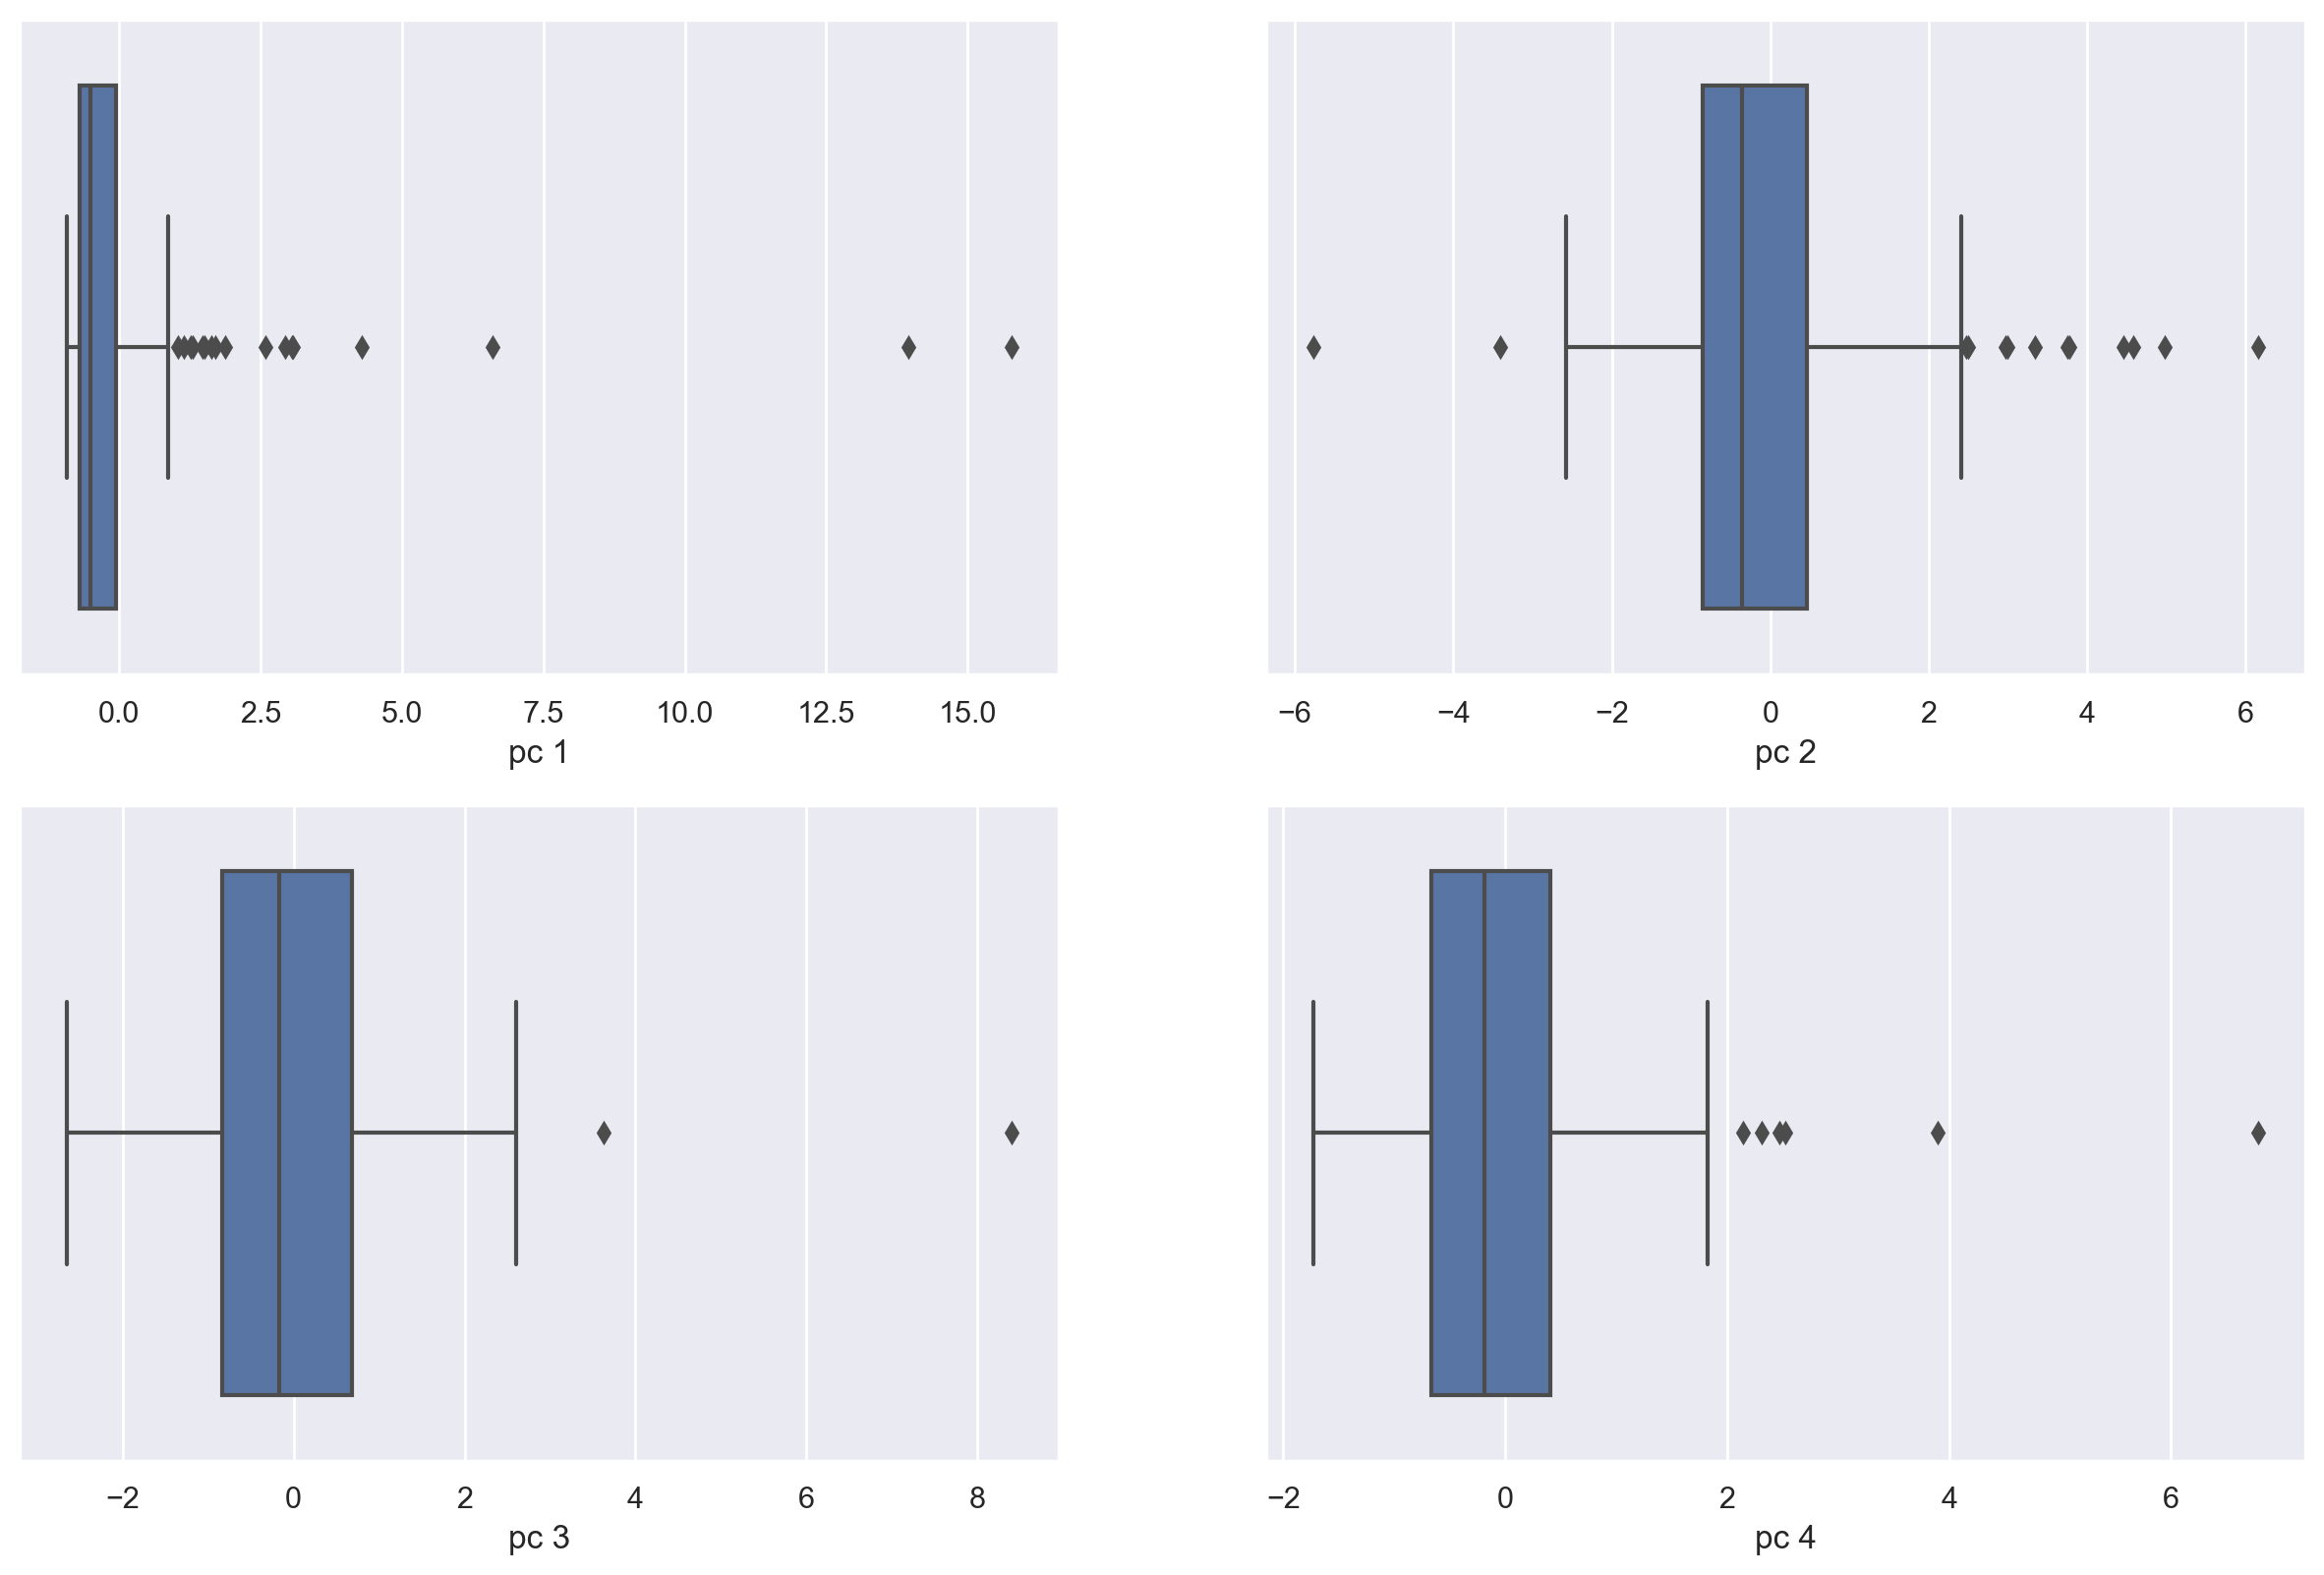

In [43]:
#Looking for outliers graphically
plt.figure(figsize=(15,15), dpi=200)

plt.subplot(3,2,1)
sns.boxplot(x = 'pc 1', data = principal_poulet_df)

plt.subplot(3,2,2)
sns.boxplot(x = 'pc 2', data = principal_poulet_df)

plt.subplot(3,2,3)
sns.boxplot(x = 'pc 3', data = principal_poulet_df)

plt.subplot(3,2,4)
sns.boxplot(x = 'pc 4', data = principal_poulet_df)

In [44]:
#Looking for outliers using the z-score
z = np.abs(stats.zscore(principal_poulet_df[['pc 1', 'pc 2', 'pc 3', 'pc 4']]))

# selecting 3 as the threshold to identify outliers
print('Below are the outlier points along with the respective column numbers in the second array')
print("\n")
print(np.where(z > 3))

Below are the outlier points along with the respective column numbers in the second array


(array([  7,   7,  21,  34,  34,  46,  67, 116, 123, 123, 160, 167],
      dtype=int64), array([1, 2, 0, 0, 1, 1, 3, 1, 1, 2, 3, 0], dtype=int64))


<font color='blue'>From this we can identify China, Brazil and the United States as the main outliers due to their GDP as well as the large amount of Poultry products they export and the small amount they import. They are our main competitors.</font>

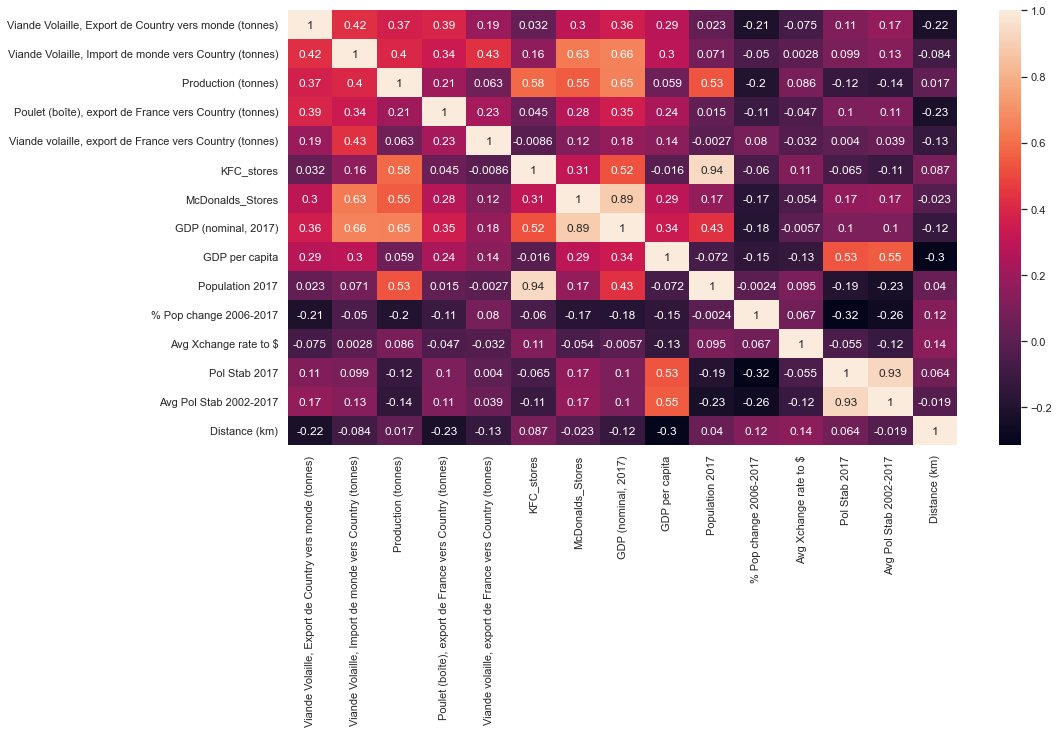

In [45]:
#Testing if outliers have effect on overall correlation
full_data_no_outliers = full_data[(full_data.Country != 'Chine, continentale') 
                                  & (full_data.Country != 'États-Unis d\'Amérique')
                                  & (full_data.Country != 'Brésil')]
corrMatrix = full_data_no_outliers.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corrMatrix, annot=True)
plt.show()

<font color='blue'>After removing the outliers we can see that the correlation between population 2017 and KFC Stores has increased while the correlation between McDonalds Stores and GDP has decreased. It is best to continue the analysis by removing KFC Stores and adding back McDonalds Stores</font>

In [46]:
full_data_no_out_no_corr = full_data_no_outliers.drop(['KFC_stores','Avg Pol Stab 2002-2017'],axis=1)
full_data_no_out_no_corr

,Country,"Viande Volaille, Export de Country vers monde (tonnes)","Viande Volaille, Import de monde vers Country (tonnes)",Production (tonnes),"Poulet (boîte), export de France vers Country (tonnes)","Viande volaille, export de France vers Country (tonnes)",McDonalds_Stores,"GDP (nominal, 2017)",GDP per capita,Population 2017,% Pop change 2006-2017,Avg Xchange rate to $,Pol Stab 2017,Distance (km)
0,Afghanistan,0,29000,28000,0.0,244.0,0.0,1.954398e+10,538.0,36296110.0,37.313363,68.026904,-2.80,5583.528
1,Afrique du Sud,63000,514000,1667000,1.0,0.0,252.0,3.488716e+11,6120.0,57009760.0,17.571447,13.333781,-0.28,9063.963
2,Albanie,0,38000,13000,10.0,78.0,0.0,1.303854e+10,4521.0,2884170.0,-5.839009,119.099667,0.38,1635.822
3,Algérie,0,2000,275000,46.0,0.0,0.0,1.675553e+11,4048.0,41389190.0,23.031985,110.973017,-0.92,2316.022
4,Allemagne,646000,842000,1514000,1377.0,18920.0,1476.0,3.693204e+12,44680.0,82658410.0,1.455932,0.885206,0.59,632.765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,Égypte,1000,110000,1118000,10.0,6623.0,0.0,2.353691e+11,2441.0,96442590.0,25.455962,17.782534,0.00,3420.795
165,Émirats arabes unis,94000,433000,48000,278.0,7557.0,165.0,3.825751e+11,40325.0,9487200.0,78.998032,3.672500,0.62,5249.794
166,Équateur,0,0,340000,0.0,0.0,0.0,1.042959e+11,6214.0,16785360.0,19.389048,1.000000,0.00,9515.114
168,Éthiopie,0,1000,14000,20.0,42.0,0.0,0.000000e+00,0.0,106399920.0,35.559932,23.866104,-1.68,5660.203


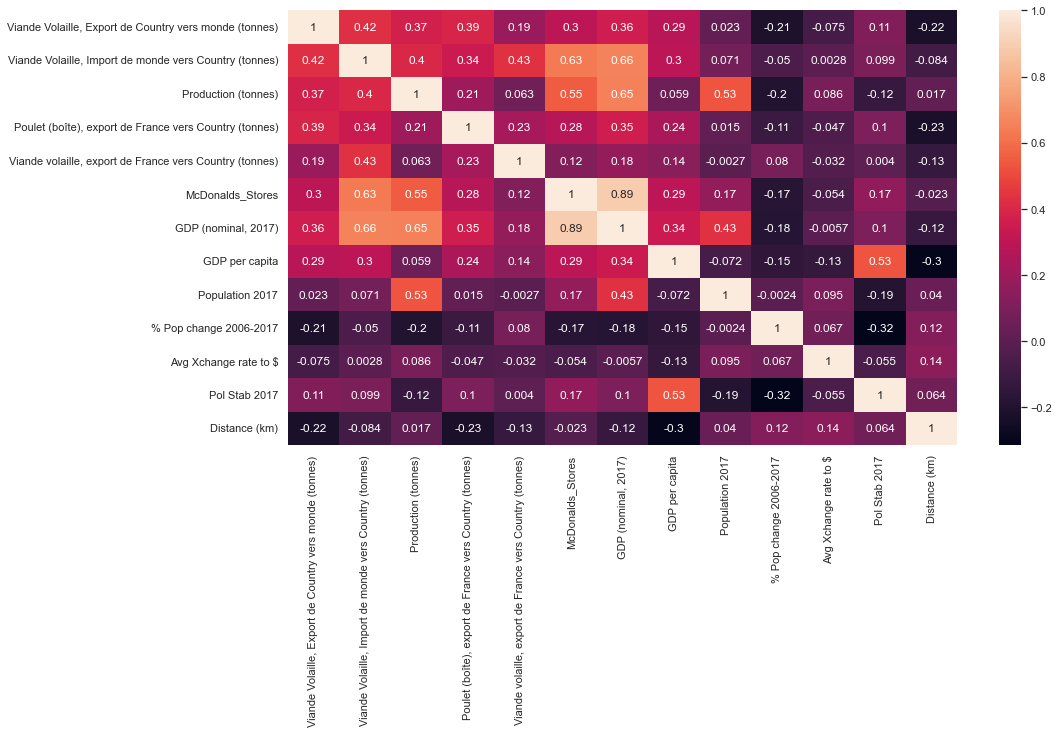

In [47]:
corrMatrix = full_data_no_out_no_corr.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### Redoing PCA without outliers and no highly correlated feautures

In [48]:
#Preparing dataframe for scaling
full_no_outliers_to_scale = full_data_no_out_no_corr.set_index('Country')
full_no_outliers_to_scale

,"Viande Volaille, Export de Country vers monde (tonnes)","Viande Volaille, Import de monde vers Country (tonnes)",Production (tonnes),"Poulet (boîte), export de France vers Country (tonnes)","Viande volaille, export de France vers Country (tonnes)",McDonalds_Stores,"GDP (nominal, 2017)",GDP per capita,Population 2017,% Pop change 2006-2017,Avg Xchange rate to $,Pol Stab 2017,Distance (km)
Country,,,,,,,,,,,,,
Afghanistan,0,29000,28000,0.0,244.0,0.0,1.954398e+10,538.0,36296110.0,37.313363,68.026904,-2.80,5583.528
Afrique du Sud,63000,514000,1667000,1.0,0.0,252.0,3.488716e+11,6120.0,57009760.0,17.571447,13.333781,-0.28,9063.963
Albanie,0,38000,13000,10.0,78.0,0.0,1.303854e+10,4521.0,2884170.0,-5.839009,119.099667,0.38,1635.822
Algérie,0,2000,275000,46.0,0.0,0.0,1.675553e+11,4048.0,41389190.0,23.031985,110.973017,-0.92,2316.022
Allemagne,646000,842000,1514000,1377.0,18920.0,1476.0,3.693204e+12,44680.0,82658410.0,1.455932,0.885206,0.59,632.765
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Égypte,1000,110000,1118000,10.0,6623.0,0.0,2.353691e+11,2441.0,96442590.0,25.455962,17.782534,0.00,3420.795
Émirats arabes unis,94000,433000,48000,278.0,7557.0,165.0,3.825751e+11,40325.0,9487200.0,78.998032,3.672500,0.62,5249.794
Équateur,0,0,340000,0.0,0.0,0.0,1.042959e+11,6214.0,16785360.0,19.389048,1.000000,0.00,9515.114


In [49]:
full_no_outliers_scaled = StandardScaler().fit_transform(full_no_outliers_to_scale)
np.mean(full_no_outliers_scaled),np.std(full_no_outliers_scaled)

(-5.727543931737334e-18, 1.0)

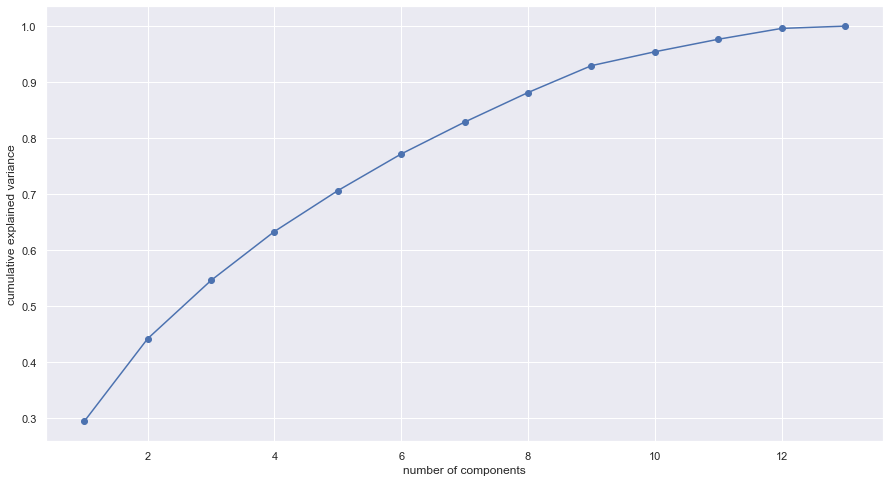

In [50]:
#Verifying if 4 is still an adequate amount of components
pca3 = PCA().fit(full_no_outliers_scaled)
plt.plot(range(1,14), np.cumsum(pca3.explained_variance_ratio_), marker = "o")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

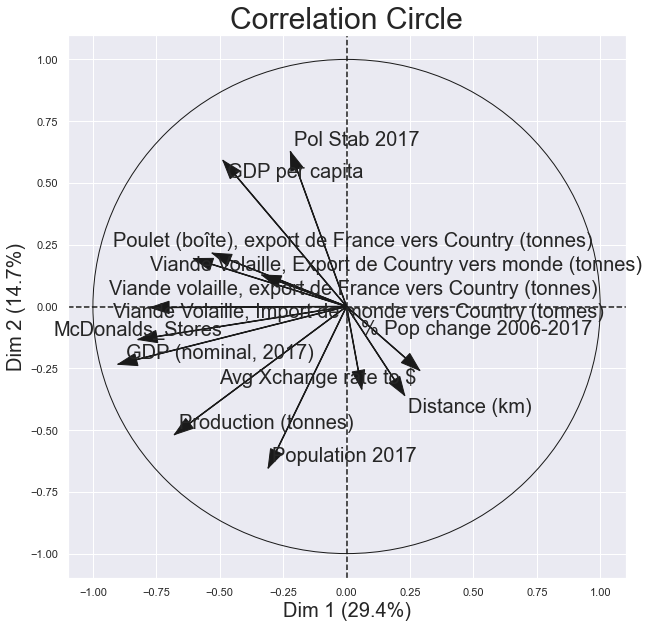

In [51]:
attribute_names = full_no_outliers_to_scale.columns
fig, correlation_matrix = plot_pca_correlation_graph(
    full_no_outliers_scaled, 
    attribute_names,
    dimensions=(1, 2),
    figure_axis_size=10
    )

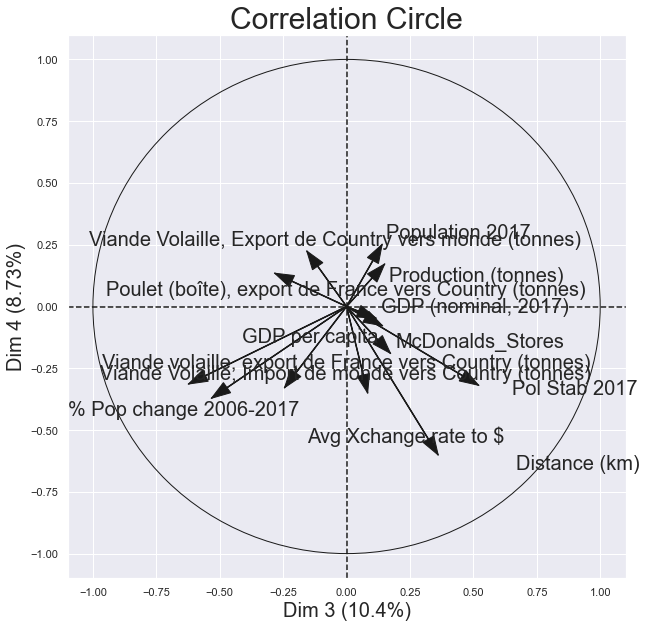

In [52]:
attribute_names = full_no_outliers_to_scale.columns
fig, correlation_matrix = plot_pca_correlation_graph(
    full_no_outliers_scaled, 
    attribute_names,
    dimensions=(3, 4),
    figure_axis_size=10
    )

In [53]:
pca4 = PCA(n_components = 4)
pca4.fit_transform(full_no_outliers_scaled)

array([[-1.45740136e+00,  1.63177746e+00,  1.94283058e+00,
        -7.47170939e-01],
       [ 1.49815723e+00,  1.27353507e+00, -5.93931011e-02,
         6.80428901e-01],
       [-5.49847339e-01, -9.55307055e-01, -5.01199930e-01,
        -1.03626837e+00],
       [-7.78175515e-01,  4.15473452e-01,  7.32009160e-01,
        -9.73375877e-01],
       [ 8.70827946e+00, -2.78172307e-01,  6.27344167e-01,
         9.17143965e-01],
       [-6.30110370e-01,  5.23447350e-01,  1.13706349e+00,
         9.39450576e-01],
       [-7.75179840e-01, -8.63351511e-01, -6.12963553e-01,
         2.36423439e-01],
       [ 3.85714412e+00, -6.62469389e-01,  7.71607750e+00,
         4.60230213e+00],
       [ 1.20680395e+00,  1.06188074e+00, -1.22274072e+00,
        -5.54758858e-02],
       [-7.96699764e-01, -2.18544532e-01,  2.79667050e-03,
        -9.42684507e-01],
       [ 6.32191365e-01,  1.00902659e+00, -1.73817957e+00,
         1.64099567e+00],
       [ 9.27253988e-01, -2.00313411e+00, -7.34036408e-01,
      

In [54]:
pca_no_outliers_poulet = pca4.fit_transform(full_no_outliers_scaled)

In [55]:
#Creating a dataframe with the PCA results
pca_no_outliers_poulet_df = pd.DataFrame(data = pca_no_outliers_poulet
             , columns = ['pc 1', 'pc 2', 'pc 3', 'pc 4'])
pca_no_outliers_poulet_df

,pc 1,pc 2,pc 3,pc 4
0,-1.457401,1.631777,1.942831,-0.747171
1,1.498157,1.273535,-0.059393,0.680429
2,-0.549847,-0.955307,-0.501200,-1.036268
3,-0.778176,0.415473,0.732009,-0.973376
4,8.708279,-0.278172,0.627344,0.917144
...,...,...,...,...
162,0.155379,0.687105,0.603590,-0.352739
163,0.805499,-0.706895,2.075182,2.340230
164,-0.874556,0.236580,-0.389163,0.318195
165,-1.289582,1.350232,1.217605,-0.611375


# Step 5a: K-Means clustering after PCA

In [56]:
#Finding the appropriate number of clusters using the Within Cluster Sum of Squares (WCSS) method
wcss = []
cl_num = 20
for i in range (1,cl_num):
    kmeans_pca = KMeans(n_clusters = i, init = "k-means++", random_state = 147)
    kmeans_pca.fit(pca_no_outliers_poulet)
    wcss.append(kmeans_pca.inertia_)

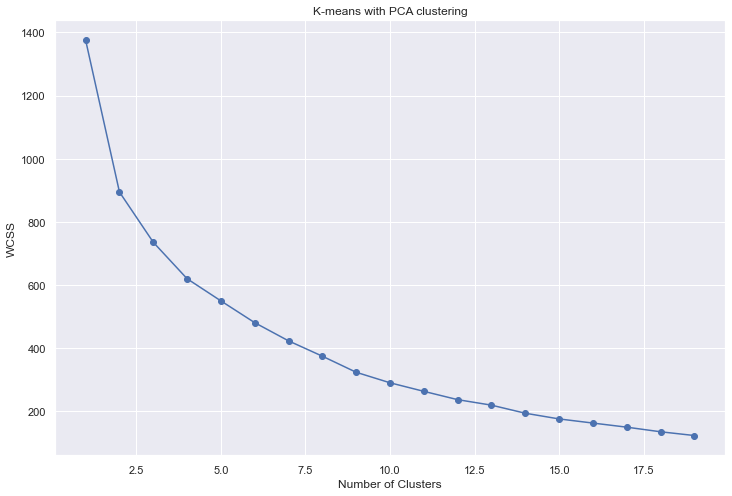

In [57]:
plt.figure(figsize = (12,8))
plt.plot(range(1,cl_num), wcss, marker = "o")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("K-means with PCA clustering")
plt.show()

#### Performing KMeans clustering using the appropriate number of Clusters, i.e. 4

In [58]:
kmeans_pca = KMeans(n_clusters = 4, init = "k-means++", random_state = 147)
kmeans_pca.fit(pca_no_outliers_poulet)

KMeans(n_clusters=4, random_state=147)

#### Putting it all together

In [59]:
#Concating the full dataframe with the PCA results and creating a new feature with the KMeans segments
full_data_pca_clusters = pd.concat([full_data_no_out_no_corr.reset_index(drop = True), pca_no_outliers_poulet_df], axis = 1)
full_data_pca_clusters["Segment K-means PCA"] = kmeans_pca.labels_
full_data_pca_clusters

,Country,"Viande Volaille, Export de Country vers monde (tonnes)","Viande Volaille, Import de monde vers Country (tonnes)",Production (tonnes),"Poulet (boîte), export de France vers Country (tonnes)","Viande volaille, export de France vers Country (tonnes)",McDonalds_Stores,"GDP (nominal, 2017)",GDP per capita,Population 2017,% Pop change 2006-2017,Avg Xchange rate to $,Pol Stab 2017,Distance (km),pc 1,pc 2,pc 3,pc 4,Segment K-means PCA
0,Afghanistan,0,29000,28000,0.0,244.0,0.0,1.954398e+10,538.0,36296110.0,37.313363,68.026904,-2.80,5583.528,-1.457401,1.631777,1.942831,-0.747171,3
1,Afrique du Sud,63000,514000,1667000,1.0,0.0,252.0,3.488716e+11,6120.0,57009760.0,17.571447,13.333781,-0.28,9063.963,1.498157,1.273535,-0.059393,0.680429,1
2,Albanie,0,38000,13000,10.0,78.0,0.0,1.303854e+10,4521.0,2884170.0,-5.839009,119.099667,0.38,1635.822,-0.549847,-0.955307,-0.501200,-1.036268,0
3,Algérie,0,2000,275000,46.0,0.0,0.0,1.675553e+11,4048.0,41389190.0,23.031985,110.973017,-0.92,2316.022,-0.778176,0.415473,0.732009,-0.973376,3
4,Allemagne,646000,842000,1514000,1377.0,18920.0,1476.0,3.693204e+12,44680.0,82658410.0,1.455932,0.885206,0.59,632.765,8.708279,-0.278172,0.627344,0.917144,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Égypte,1000,110000,1118000,10.0,6623.0,0.0,2.353691e+11,2441.0,96442590.0,25.455962,17.782534,0.00,3420.795,0.155379,0.687105,0.603590,-0.352739,3
163,Émirats arabes unis,94000,433000,48000,278.0,7557.0,165.0,3.825751e+11,40325.0,9487200.0,78.998032,3.672500,0.62,5249.794,0.805499,-0.706895,2.075182,2.340230,3
164,Équateur,0,0,340000,0.0,0.0,0.0,1.042959e+11,6214.0,16785360.0,19.389048,1.000000,0.00,9515.114,-0.874556,0.236580,-0.389163,0.318195,3
165,Éthiopie,0,1000,14000,20.0,42.0,0.0,0.000000e+00,0.0,106399920.0,35.559932,23.866104,-1.68,5660.203,-1.289582,1.350232,1.217605,-0.611375,3


In [60]:
full_data_pca_clusters["KMeans segment"] = full_data_pca_clusters["Segment K-means PCA"].map({0:"group 1",
                                                                                              1:"group 2",
                                                                                              2:"group 3",
                                                                                              3:"group 4"})
full_data_pca_clusters.drop(["Segment K-means PCA"], axis=1, inplace=True)
full_data_pca_clusters

,Country,"Viande Volaille, Export de Country vers monde (tonnes)","Viande Volaille, Import de monde vers Country (tonnes)",Production (tonnes),"Poulet (boîte), export de France vers Country (tonnes)","Viande volaille, export de France vers Country (tonnes)",McDonalds_Stores,"GDP (nominal, 2017)",GDP per capita,Population 2017,% Pop change 2006-2017,Avg Xchange rate to $,Pol Stab 2017,Distance (km),pc 1,pc 2,pc 3,pc 4,KMeans segment
0,Afghanistan,0,29000,28000,0.0,244.0,0.0,1.954398e+10,538.0,36296110.0,37.313363,68.026904,-2.80,5583.528,-1.457401,1.631777,1.942831,-0.747171,group 4
1,Afrique du Sud,63000,514000,1667000,1.0,0.0,252.0,3.488716e+11,6120.0,57009760.0,17.571447,13.333781,-0.28,9063.963,1.498157,1.273535,-0.059393,0.680429,group 2
2,Albanie,0,38000,13000,10.0,78.0,0.0,1.303854e+10,4521.0,2884170.0,-5.839009,119.099667,0.38,1635.822,-0.549847,-0.955307,-0.501200,-1.036268,group 1
3,Algérie,0,2000,275000,46.0,0.0,0.0,1.675553e+11,4048.0,41389190.0,23.031985,110.973017,-0.92,2316.022,-0.778176,0.415473,0.732009,-0.973376,group 4
4,Allemagne,646000,842000,1514000,1377.0,18920.0,1476.0,3.693204e+12,44680.0,82658410.0,1.455932,0.885206,0.59,632.765,8.708279,-0.278172,0.627344,0.917144,group 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Égypte,1000,110000,1118000,10.0,6623.0,0.0,2.353691e+11,2441.0,96442590.0,25.455962,17.782534,0.00,3420.795,0.155379,0.687105,0.603590,-0.352739,group 4
163,Émirats arabes unis,94000,433000,48000,278.0,7557.0,165.0,3.825751e+11,40325.0,9487200.0,78.998032,3.672500,0.62,5249.794,0.805499,-0.706895,2.075182,2.340230,group 4
164,Équateur,0,0,340000,0.0,0.0,0.0,1.042959e+11,6214.0,16785360.0,19.389048,1.000000,0.00,9515.114,-0.874556,0.236580,-0.389163,0.318195,group 4
165,Éthiopie,0,1000,14000,20.0,42.0,0.0,0.000000e+00,0.0,106399920.0,35.559932,23.866104,-1.68,5660.203,-1.289582,1.350232,1.217605,-0.611375,group 4


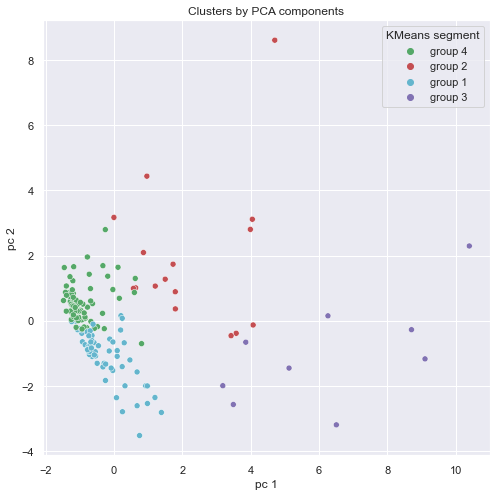

In [61]:
#A scatterplot using the 1st and 2nd Principal Components and their division into clusters using the KMeans method
x_axis = full_data_pca_clusters["pc 1"]
y_axis = full_data_pca_clusters["pc 2"]
plt.figure(figsize = (8,8))
sns.scatterplot(x_axis, y_axis, hue = full_data_pca_clusters["KMeans segment"], palette = ['g','r','c','m'])
plt.title("Clusters by PCA components")
plt.show()

In [62]:
#Grouping the clusters and using the average to see how the groups were split
cluster_grouped = full_data_pca_clusters.groupby(["KMeans segment"]).mean()
cluster_grouped

,"Viande Volaille, Export de Country vers monde (tonnes)","Viande Volaille, Import de monde vers Country (tonnes)",Production (tonnes),"Poulet (boîte), export de France vers Country (tonnes)","Viande volaille, export de France vers Country (tonnes)",McDonalds_Stores,"GDP (nominal, 2017)",GDP per capita,Population 2017,% Pop change 2006-2017,Avg Xchange rate to $,Pol Stab 2017,Distance (km),pc 1,pc 2,pc 3,pc 4
KMeans segment,,,,,,,,,,,,,,,,,
group 1,21426.229508,40672.131148,1.160984e+05,129.245902,483.803279,41.967213,9.671060e+10,21377.360656,4.587351e+06,6.330084,82.194429,0.653115,5142.938148,-0.270805,-1.052308,-0.684555,-0.139764
group 2,193062.500000,176312.500000,2.021188e+06,289.125000,340.687500,445.312500,9.493039e+11,12485.375000,1.604267e+08,11.891409,2322.074480,-0.181250,8175.979063,2.178915,1.911051,-0.895103,-0.047697
group 3,497222.222222,664000.000000,1.223444e+06,5958.000000,19957.333333,914.777778,1.939314e+12,38892.111111,5.080302e+07,8.195603,14.323602,0.465556,3012.940556,6.293762,-0.990019,1.608663,0.692077
group 4,5962.962963,41530.864198,2.104815e+05,41.481481,829.345679,11.580247,6.200108e+10,3355.740741,2.507695e+07,27.774783,674.255210,-0.619136,6471.995840,-0.925771,0.524990,0.513600,0.037778


<font color='blue'>What we can see is that:</font>
    
<font color='blue'>Groups 1 & 4 have relatively low production as well as import and export of Poultry products. They import little from France, have a relatively low GDP and a correspondingly low average number of McDonalds Stores. They are on the low end of Population numbers but group 4 has the highest average population change. Group 4 also has the lowest average political stability.</font>
    
<font color='blue'>Group 3 has high production and also imports and exports a lot of poultry products. They import the most from France out of any group, have the highest average GDP and the most McDonalds. They have an above average population, the lowest exchange rate and are politically stable. They are also the group that is closest geographically to France.
</font>

# Step 5b: Hierarchical clustering after PCA

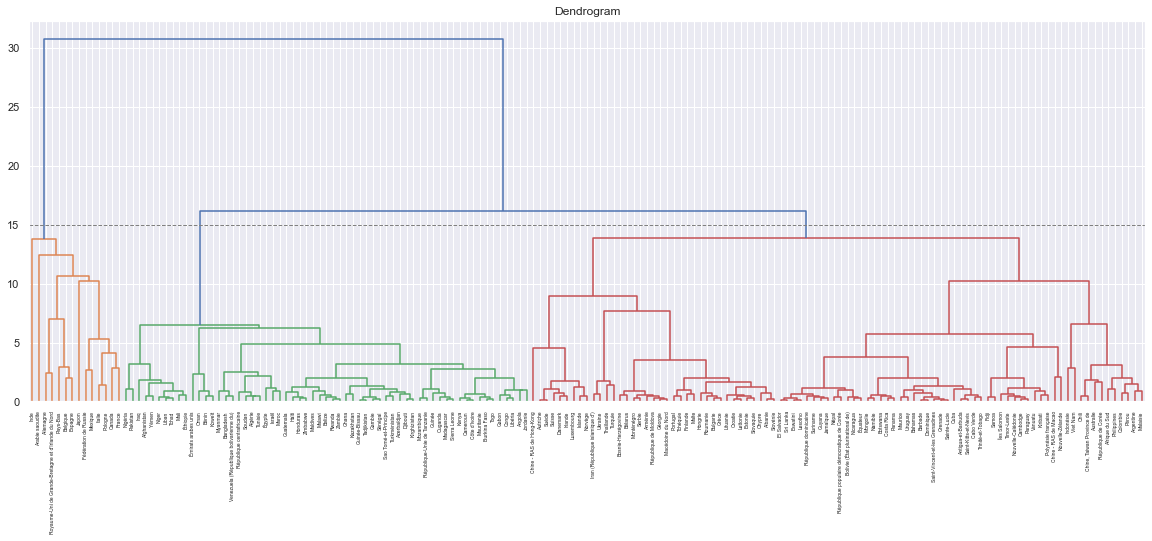

In [85]:
#Creating a dendrogram 
max_d = 15
plt.figure(figsize=(20,7))  
plt.title("Dendrogram")
Z = shc.linkage(pca_no_outliers_poulet_df, 'ward')
shc.dendrogram(Z, color_threshold=max_d, labels=full_no_outliers_to_scale.index)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')

<font color='blue'>Visually we can conclude there are 3 main clusters. However, for ease of comparison it's been decided to work with the same number of clusters for both methods</font>

#### Creating clusters using the same amount as found using the WCSS

In [64]:
k=4
hierarchy_pca = shc.fcluster(Z, k, criterion='maxclust')
hierarchy_pca

array([2, 4, 3, 2, 1, 2, 4, 1, 4, 3, 4, 3, 2, 4, 2, 4, 1, 2, 4, 3, 4, 3,
       2, 3, 2, 4, 4, 2, 1, 4, 3, 4, 4, 3, 4, 2, 4, 3, 4, 2, 3, 2, 4, 4,
       1, 3, 4, 4, 3, 1, 1, 2, 2, 2, 4, 3, 2, 2, 2, 4, 3, 2, 2, 3, 1, 4,
       3, 2, 3, 3, 2, 1, 4, 1, 2, 2, 2, 2, 4, 2, 4, 3, 2, 2, 3, 3, 3, 2,
       4, 2, 2, 2, 3, 2, 4, 2, 1, 4, 3, 2, 2, 4, 4, 2, 2, 3, 4, 4, 4, 2,
       2, 2, 4, 4, 1, 4, 1, 4, 3, 4, 3, 1, 2, 2, 4, 3, 4, 4, 2, 4, 4, 4,
       4, 2, 3, 2, 3, 3, 2, 4, 3, 4, 3, 2, 2, 2, 3, 3, 4, 2, 4, 2, 2, 3,
       3, 4, 4, 2, 4, 2, 2, 2, 2, 2, 4, 2, 4], dtype=int32)

In [65]:
hierarchy_pca_df = pd.DataFrame(data = hierarchy_pca, columns = ["Segment Hierarchy PCA"])
hierarchy_pca_df

,Segment Hierarchy PCA
0,2
1,4
2,3
3,2
4,1
...,...
162,2
163,2
164,4
165,2


In [66]:
#Concating the resultant hierarchical clusters with the dataframe
full_pca_clust_hier = pd.concat([full_data_pca_clusters.reset_index(drop = True), hierarchy_pca_df], axis = 1)
full_pca_clust_hier.head()

,Country,"Viande Volaille, Export de Country vers monde (tonnes)","Viande Volaille, Import de monde vers Country (tonnes)",Production (tonnes),"Poulet (boîte), export de France vers Country (tonnes)","Viande volaille, export de France vers Country (tonnes)",McDonalds_Stores,"GDP (nominal, 2017)",GDP per capita,Population 2017,% Pop change 2006-2017,Avg Xchange rate to $,Pol Stab 2017,Distance (km),pc 1,pc 2,pc 3,pc 4,KMeans segment,Segment Hierarchy PCA
0,Afghanistan,0,29000,28000,0.0,244.0,0.0,1.954398e+10,538.0,36296110.0,37.313363,68.026904,-2.80,5583.528,-1.457401,1.631777,1.942831,-0.747171,group 4,2
1,Afrique du Sud,63000,514000,1667000,1.0,0.0,252.0,3.488716e+11,6120.0,57009760.0,17.571447,13.333781,-0.28,9063.963,1.498157,1.273535,-0.059393,0.680429,group 2,4
2,Albanie,0,38000,13000,10.0,78.0,0.0,1.303854e+10,4521.0,2884170.0,-5.839009,119.099667,0.38,1635.822,-0.549847,-0.955307,-0.501200,-1.036268,group 1,3
3,Algérie,0,2000,275000,46.0,0.0,0.0,1.675553e+11,4048.0,41389190.0,23.031985,110.973017,-0.92,2316.022,-0.778176,0.415473,0.732009,-0.973376,group 4,2
4,Allemagne,646000,842000,1514000,1377.0,18920.0,1476.0,3.693204e+12,44680.0,82658410.0,1.455932,0.885206,0.59,632.765,8.708279,-0.278172,0.627344,0.917144,group 3,1


In [67]:
full_pca_clust_hier["Hierarchy segment"] = full_pca_clust_hier["Segment Hierarchy PCA"].map({1:"group 3",
                                                                                             2:"group 4",
                                                                                             3:"group 1",
                                                                                             4:"group 2",
                                                                                             })
full_pca_clust_hier.drop(["Segment Hierarchy PCA"], axis=1, inplace=True)
full_pca_clust_hier

,Country,"Viande Volaille, Export de Country vers monde (tonnes)","Viande Volaille, Import de monde vers Country (tonnes)",Production (tonnes),"Poulet (boîte), export de France vers Country (tonnes)","Viande volaille, export de France vers Country (tonnes)",McDonalds_Stores,"GDP (nominal, 2017)",GDP per capita,Population 2017,% Pop change 2006-2017,Avg Xchange rate to $,Pol Stab 2017,Distance (km),pc 1,pc 2,pc 3,pc 4,KMeans segment,Hierarchy segment
0,Afghanistan,0,29000,28000,0.0,244.0,0.0,1.954398e+10,538.0,36296110.0,37.313363,68.026904,-2.80,5583.528,-1.457401,1.631777,1.942831,-0.747171,group 4,group 4
1,Afrique du Sud,63000,514000,1667000,1.0,0.0,252.0,3.488716e+11,6120.0,57009760.0,17.571447,13.333781,-0.28,9063.963,1.498157,1.273535,-0.059393,0.680429,group 2,group 2
2,Albanie,0,38000,13000,10.0,78.0,0.0,1.303854e+10,4521.0,2884170.0,-5.839009,119.099667,0.38,1635.822,-0.549847,-0.955307,-0.501200,-1.036268,group 1,group 1
3,Algérie,0,2000,275000,46.0,0.0,0.0,1.675553e+11,4048.0,41389190.0,23.031985,110.973017,-0.92,2316.022,-0.778176,0.415473,0.732009,-0.973376,group 4,group 4
4,Allemagne,646000,842000,1514000,1377.0,18920.0,1476.0,3.693204e+12,44680.0,82658410.0,1.455932,0.885206,0.59,632.765,8.708279,-0.278172,0.627344,0.917144,group 3,group 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Égypte,1000,110000,1118000,10.0,6623.0,0.0,2.353691e+11,2441.0,96442590.0,25.455962,17.782534,0.00,3420.795,0.155379,0.687105,0.603590,-0.352739,group 4,group 4
163,Émirats arabes unis,94000,433000,48000,278.0,7557.0,165.0,3.825751e+11,40325.0,9487200.0,78.998032,3.672500,0.62,5249.794,0.805499,-0.706895,2.075182,2.340230,group 4,group 4
164,Équateur,0,0,340000,0.0,0.0,0.0,1.042959e+11,6214.0,16785360.0,19.389048,1.000000,0.00,9515.114,-0.874556,0.236580,-0.389163,0.318195,group 4,group 2
165,Éthiopie,0,1000,14000,20.0,42.0,0.0,0.000000e+00,0.0,106399920.0,35.559932,23.866104,-1.68,5660.203,-1.289582,1.350232,1.217605,-0.611375,group 4,group 4


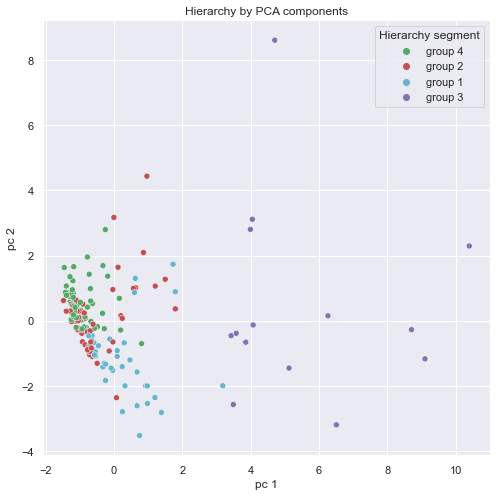

In [68]:
#A scatterplot using the 1st and 2nd Principal Components and their division into clusters using the hierarchical method
x_axis = full_pca_clust_hier["pc 1"]
y_axis = full_pca_clust_hier["pc 2"]
plt.figure(figsize = (8,8))
sns.scatterplot(x_axis, y_axis, hue = full_pca_clust_hier["Hierarchy segment"], palette = ['g','r','c','m'])
plt.title("Hierarchy by PCA components")
plt.show()

In [69]:
#comparing the 4 groups using the mean of each feature
hierarchy_grouped = full_pca_clust_hier.groupby(["Hierarchy segment"]).mean()
hierarchy_grouped

,"Viande Volaille, Export de Country vers monde (tonnes)","Viande Volaille, Import de monde vers Country (tonnes)",Production (tonnes),"Poulet (boîte), export de France vers Country (tonnes)","Viande volaille, export de France vers Country (tonnes)",McDonalds_Stores,"GDP (nominal, 2017)",GDP per capita,Population 2017,% Pop change 2006-2017,Avg Xchange rate to $,Pol Stab 2017,Distance (km),pc 1,pc 2,pc 3,pc 4
Hierarchy segment,,,,,,,,,,,,,,,,,
group 1,90108.108108,70405.405405,2.993784e+05,209.378378,1131.324324,56.810811,1.827518e+11,25633.783784,1.237455e+07,2.381692,34.902165,0.362973,2019.711000,0.260297,-1.170696,-0.349834,-0.811664
group 2,10054.545455,44872.727273,3.522364e+05,28.800000,62.618182,70.745455,1.142907e+11,9273.018182,1.810416e+07,12.634148,993.023990,0.354909,9905.352255,-0.532146,0.068181,-0.804047,0.604772
group 3,379357.142857,471500.000000,1.950571e+06,4142.357143,12364.785714,856.714286,1.900702e+12,29721.142857,1.567331e+08,8.156058,19.248024,0.226429,3435.660786,5.520072,0.474571,0.525170,-0.137858
group 4,2557.377049,48655.737705,1.593934e+05,35.540984,1038.459016,14.245902,6.404080e+10,4115.852459,2.766006e+07,32.831638,667.761711,-0.740000,5381.312918,-0.944983,0.539702,0.816624,-0.021326


<font color='blue'>What we can see is that:</font>
    
<font color='blue'>Groups 2 & 4 have relatively low production as well as import and export of Poultry products. They import little from France and have a relatively low GDP. They have average Population numbers but group 2 has the highest average population change. Group 2 also has the lowest average political stability. Both groups have very high exchange rates.</font>
    
<font color='blue'>Group 3 has high production and also imports and exports a lot of poultry products. They import the most from France out of any group, have the highest average GDP and the most McDonalds. They have an above average population, the lowest exchange rate and are politically stable.</font>

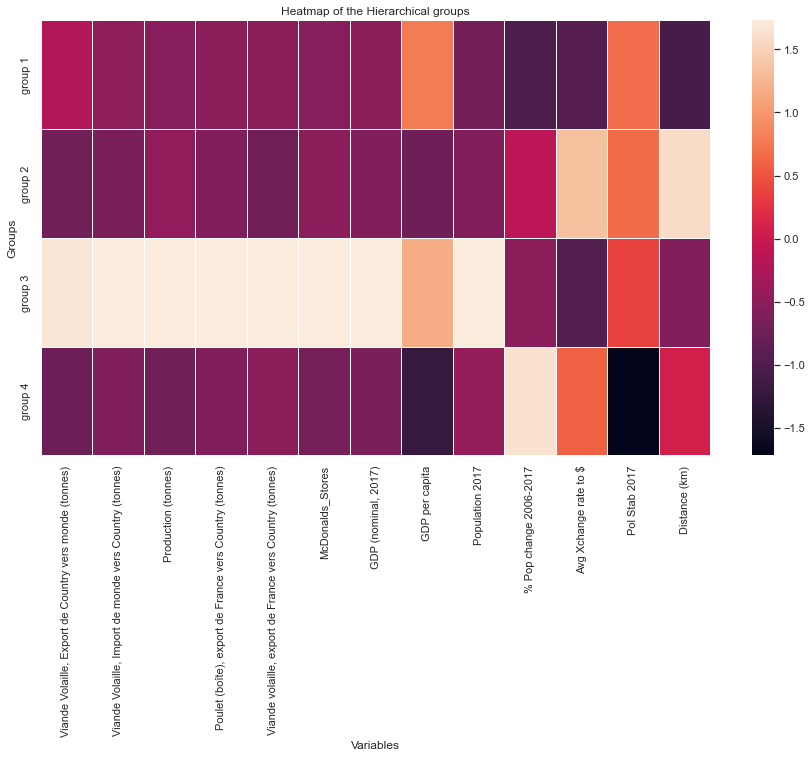

In [70]:
#Respresenting these findings visually through a heatmap
hierarchy_grouped_to_scale = hierarchy_grouped.drop(['pc 1', 'pc 2', 'pc 3', 'pc 4'], axis=1)
hierarchy_grouped_scaled = StandardScaler().fit_transform(hierarchy_grouped_to_scale)
hierarchy_grouped_scaled_df = pd.DataFrame(hierarchy_grouped_scaled, columns = hierarchy_grouped_to_scale.columns,
                                          index = hierarchy_grouped_to_scale.index)

ax = sns.heatmap(hierarchy_grouped_scaled_df, linewidth=0.5)
ax.set(title="Heatmap of the Hierarchical groups",
      xlabel="Variables",
      ylabel="Groups",)
plt.show()

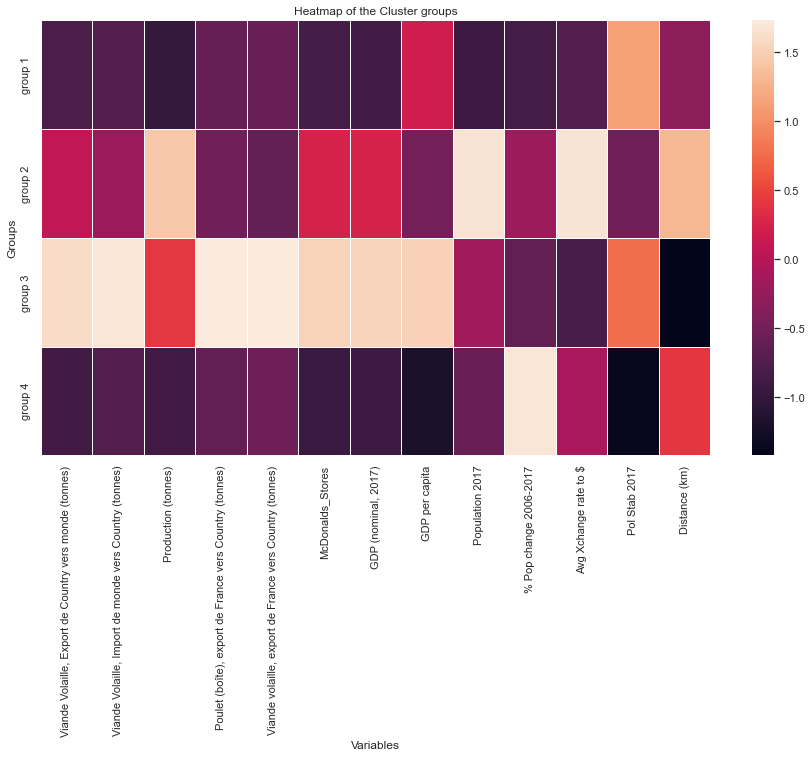

In [71]:
#for easy comparison
cluster_grouped_to_scale = cluster_grouped.drop(['pc 1', 'pc 2', 'pc 3', 'pc 4'], axis=1)
cluster_grouped_scaled = StandardScaler().fit_transform(cluster_grouped_to_scale)
cluster_grouped_scaled_df = pd.DataFrame(cluster_grouped_scaled, columns = cluster_grouped_to_scale.columns,
                                          index = cluster_grouped_to_scale.index)

ax = sns.heatmap(cluster_grouped_scaled_df, linewidth=0.5)
ax.set(title="Heatmap of the Cluster groups",
      xlabel="Variables",
      ylabel="Groups",)
plt.show()

In [78]:
#Finding the countries that are part of the most interesting group
group_3_kmeans = full_pca_clust_hier[full_pca_clust_hier["KMeans segment"] == "group 3"]
group_3_kmeans

,Country,"Viande Volaille, Export de Country vers monde (tonnes)","Viande Volaille, Import de monde vers Country (tonnes)",Production (tonnes),"Poulet (boîte), export de France vers Country (tonnes)","Viande volaille, export de France vers Country (tonnes)",McDonalds_Stores,"GDP (nominal, 2017)",GDP per capita,Population 2017,% Pop change 2006-2017,Avg Xchange rate to $,Pol Stab 2017,Distance (km),pc 1,pc 2,pc 3,pc 4,KMeans segment,Hierarchy segment
4,Allemagne,646000,842000,1514000,1377.0,18920.0,1476.0,3.693204e+12,44680.0,82658410.0,1.455932,0.885206,0.59,632.765,8.708279,-0.278172,0.627344,0.917144,group 3,group 3
7,Arabie saoudite,10000,722000,616000,611.0,97510.0,263.0,6.867384e+11,20747.0,33101180.0,35.116177,3.750000,-0.58,4634.583,3.857144,-0.662469,7.716078,4.602302,group 3,group 3
16,Belgique,656000,338000,463000,7166.0,12577.0,74.0,4.947636e+11,43325.0,11419750.0,7.535868,0.885206,0.43,238.288,3.492106,-2.577272,1.974339,-1.084448,group 3,group 3
30,Chine - RAS de Hong-Kong,663000,907000,24000,83.0,10404.0,0.0,3.414493e+11,46733.0,7306320.0,7.413027,7.793250,0.83,9620.545,3.184623,-1.999181,0.850407,1.735685,group 3,group 1
44,Espagne,212000,205000,1515000,16697.0,13441.0,507.0,1.314314e+12,28175.0,46647430.0,4.290010,0.885206,0.28,1203.923,5.123614,-1.457541,2.090997,-1.368722,group 3,group 3
49,France,501000,506000,1750000,0.0,0.0,1419.0,2.582501e+12,39827.0,64842510.0,5.419668,0.885206,0.28,0.000,6.262959,0.147657,-0.751925,-0.333053,group 3,group 3
73,Japon,10000,1069000,2215000,2.0,122.0,2975.0,4.872415e+12,38214.0,127502730.0,-0.716384,112.166141,1.11,9605.461,10.401599,2.294177,-3.014312,3.477101,group 3,group 3
114,Pays-Bas,1418000,608000,1100000,8201.0,16149.0,245.0,8.305726e+11,48796.0,17021350.0,3.535562,0.885206,0.92,424.908,6.508919,-3.202075,2.554481,-1.364277,group 3,group 3
121,Royaume-Uni de Grande-Bretagne et d'Irlande du...,359000,779000,1814000,19485.0,10493.0,1274.0,2.637866e+12,39532.0,66727460.0,9.710569,0.777003,0.33,755.992,9.104619,-1.175291,2.430557,-0.353041,group 3,group 3


In [79]:
group_3_hier = full_pca_clust_hier[full_pca_clust_hier["Hierarchy segment"] == "group 3"]
group_3_hier

,Country,"Viande Volaille, Export de Country vers monde (tonnes)","Viande Volaille, Import de monde vers Country (tonnes)",Production (tonnes),"Poulet (boîte), export de France vers Country (tonnes)","Viande volaille, export de France vers Country (tonnes)",McDonalds_Stores,"GDP (nominal, 2017)",GDP per capita,Population 2017,% Pop change 2006-2017,Avg Xchange rate to $,Pol Stab 2017,Distance (km),pc 1,pc 2,pc 3,pc 4,KMeans segment,Hierarchy segment
4,Allemagne,646000,842000,1514000,1377.0,18920.0,1476.0,3.693204e+12,44680.0,8.265841e+07,1.455932,0.885206,0.59,632.765,8.708279,-0.278172,0.627344,0.917144,group 3,group 3
7,Arabie saoudite,10000,722000,616000,611.0,97510.0,263.0,6.867384e+11,20747.0,3.310118e+07,35.116177,3.750000,-0.58,4634.583,3.857144,-0.662469,7.716078,4.602302,group 3,group 3
16,Belgique,656000,338000,463000,7166.0,12577.0,74.0,4.947636e+11,43325.0,1.141975e+07,7.535868,0.885206,0.43,238.288,3.492106,-2.577272,1.974339,-1.084448,group 3,group 3
28,Canada,163000,182000,1417000,16.0,26.0,1450.0,1.647120e+12,44841.0,3.673210e+07,12.893356,1.297737,1.10,6614.381,4.072789,-0.133350,-1.910064,1.006348,group 2,group 3
44,Espagne,212000,205000,1515000,16697.0,13441.0,507.0,1.314314e+12,28175.0,4.664743e+07,4.290010,0.885206,0.28,1203.923,5.123614,-1.457541,2.090997,-1.368722,group 3,group 3
49,France,501000,506000,1750000,0.0,0.0,1419.0,2.582501e+12,39827.0,6.484251e+07,5.419668,0.885206,0.28,0.000,6.262959,0.147657,-0.751925,-0.333053,group 3,group 3
50,Fédération de Russie,115000,226000,4444000,4.0,0.0,645.0,1.578417e+12,10846.0,1.455301e+08,1.483104,58.342801,-0.64,5463.049,4.049260,3.115672,-1.303918,-1.305902,group 2,group 3
64,Inde,4000,0,3545000,0.0,0.0,290.0,2.650725e+12,1980.0,1.338677e+09,14.859935,65.121569,-0.76,7173.058,4.706075,8.618440,-2.470609,-3.609521,group 2,group 3
71,Italie,183000,97000,1315000,4170.0,3112.0,571.0,1.943835e+12,32038.0,6.067370e+07,3.640220,0.885206,0.31,1056.456,3.576193,-0.388668,-0.310947,-1.073864,group 2,group 3
73,Japon,10000,1069000,2215000,2.0,122.0,2975.0,4.872415e+12,38214.0,1.275027e+08,-0.716384,112.166141,1.11,9605.461,10.401599,2.294177,-3.014312,3.477101,group 3,group 3


# Conclusion:
#### Group 3 is the most interesting:
1. They are countries with high production but also high import figures
2. They are countries that are well-established as trading partners
3. They are rich countries with rich populations
4. They are countries with a Sales market (see the number of McDonalds Stores)
5. They are politically stable
6. They are countries that are close geographically, except Japan and Hong Kong and to a lesser extent Saudi Arabia

#### I would recommend starting with the countries that are part of Group 3 and are in the EU, as well as Great Britain.

#### Next would be Saudi Arabia which imports a large amount of Poultry products from France.

#### Hong Kong and Japan are interesting partners as well but would need further study for logistical reasons.